# Модуль A

In [1]:
import pandas as pd
import os
from typing import List
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import shapiro, skew
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, GradientBoostingClassifier
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, classification_report
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, roc_auc_score
import pickle 

In [2]:
outcomes = pd.read_csv("Outcomes.txt")

outcomes.head()

,RecordID,Survival,In-hospital_death
0,132539,-1,0
1,132540,-1,0
2,132541,-1,0
3,132543,575,0
4,132545,918,0


In [3]:
outcomes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   RecordID           8000 non-null   int64
 1   Survival           8000 non-null   int64
 2   In-hospital_death  8000 non-null   int64
dtypes: int64(3)
memory usage: 187.6 KB


In [4]:
ts_data = pd.read_csv("set/152022.txt")

ts_data.head()

,Time,Parameter,Value
0,00:00,RecordID,152022.0
1,00:00,Age,84.0
2,00:00,Gender,0.0
3,00:00,Height,-1.0
4,00:00,ICUType,3.0


In [5]:
def get_patient_data(file_path: str, general_params: List, ts_params: List):
    patient_params = []
    data = pd.read_csv(file_path)
    
    # Получение общих параметров
    for param in general_params:
        try:
            param_value = data[data["Parameter"] == param]["Value"].iloc[0]
            patient_params.append(param_value)
        except IndexError:
            patient_params.append(None)
    
    # Получение среднего значения временных параметров
    for param in ts_params:
        try:
            param_value = data[data["Parameter"] == param]["Value"].mean()
            patient_params.append(param_value)
        except IndexError:
            patient_params.append(None)
    
    return patient_params

    

In [6]:
general_params = ["Age", "Gender", "Height", "ICUType"]

ts_params = ["Albumin", "ALP", "ALT", "AST", "Bilirubin", "BUN", "Cholesterol", "Creatinine",
             "DiasABP", "FiO2", "GCS", "Glucose", "HCO3", "HCT", "HR", "K", "Lactate",
             "Mg", "MAP", "MechVent", "Na", "NIDiasABP", "NIMAP", "NISysABP", "PaCO2",
             "PaO2", "pH", "Platelets", "RespRate", "SaO2", "SysABP", "Temp", "TropI",
             "TropT", "Urine", "WBC", "Weight"]

In [7]:
def create_dataset(folder_path: str, general_df: pd.DataFrame, general_params: List, ts_params: List):
    patients_params = []
    for patient_id in general_df["RecordID"]:
        # Формируем относительный путь до файла
        try:
            file_path = os.path.join(folder_path, str(patient_id) + ".txt")
            # Получаем данные для одного пациента
            patient_params = get_patient_data(file_path, general_params, ts_params)
            patients_params.append(patient_params)
        except:
            patients_params.append([None] * len(general_params + ts_params))
    
    mean_params = ["Mean" + ts_param for ts_param in ts_params]

    dataset = pd.DataFrame(columns=general_params + mean_params, data=patients_params)

    general_dataset = pd.concat([general_df, dataset], axis=1)

    return general_dataset


In [8]:
dataset = create_dataset("set", outcomes, general_params, ts_params)

dataset.head()

,RecordID,Survival,In-hospital_death,Age,Gender,Height,ICUType,MeanAlbumin,MeanALP,MeanALT,...,MeanPlatelets,MeanRespRate,MeanSaO2,MeanSysABP,MeanTemp,MeanTropI,MeanTropT,MeanUrine,MeanWBC,MeanWeight
0,132539,-1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,132540,-1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,132541,-1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,132543,575,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,132545,918,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   RecordID           8000 non-null   int64  
 1   Survival           8000 non-null   int64  
 2   In-hospital_death  8000 non-null   int64  
 3   Age                288 non-null    float64
 4   Gender             288 non-null    float64
 5   Height             288 non-null    float64
 6   ICUType            288 non-null    float64
 7   MeanAlbumin        117 non-null    float64
 8   MeanALP            113 non-null    float64
 9   MeanALT            115 non-null    float64
 10  MeanAST            115 non-null    float64
 11  MeanBilirubin      114 non-null    float64
 12  MeanBUN            283 non-null    float64
 13  MeanCholesterol    20 non-null     float64
 14  MeanCreatinine     283 non-null    float64
 15  MeanDiasABP        214 non-null    float64
 16  MeanFiO2           205 n

In [10]:
dataset.to_csv("my_dataset.csv")

## Описание столбцов

1. RecordID: уникальный идентификационный номер пациента
2. Survival: Целевая переменная, содержит информацию сколько дней прожил пациент после попадания в отделение интенсивной терапии (например, 575б 918, 5 и т. д.), -1 означает что пациент жив до сих пор.
3. In-hosptial_death: Целевая переменная, содержит информацию умер человек в отделение интенсивной терапии (1) или нет (0).
4. Age: возраст пациента
5. Gender: Пол пациента (0 - женский, 1 - мужской)
6. Height: Рост пациента в сантиметрах
7. ICYType: тип отделения интенсивной терапии куда был доставлен пациент (1: Coronary Care Unit, 2: Cardiac Surgery Recovery Unit, 3: Medical ICU, or 4: Surgical ICU).
8. MeanAlbumin: Средний Альбумин (г/дл).
9. MeanALP: Средняя ЩФ [щелочная фосфатаза (МЕ/л)].
10. MeanALT: Средняя АЛТ [аланинаминотрансфераза (МЕ/л)].
11. MeanAST: Средняя АСТ [аспартатаминотрансфераза (МЕ/л)].
12. MeanBilirubin: Средний Билирубин (мг/дл).
13. MeanBUN: Средний BUN [Азот мочевины крови (мг/дл)].
14. MeanCholesterol: Средний Холестерин (мг/дл).
15. MeanCreatinine: Средний Креатинин [Сывороточный креатинин (мг/дл)].
16. MeanDiasABP: Среднее Диастолическое артериальное давление (мм рт.ст.).
17. MeanFiO2: Средний FiO2 [Фракционный уровень кислорода в крови (0-1)].
18. MeanGCS: Средний GCS [Показатель комы по шкале Глазго (3-15)].
19. MeanGlucose: Средняя Глюкоза [Уровень глюкозы в сыворотке крови (мг/дл)].
20. MeanHCO3: Среднее HCO3 [Содержание бикарбоната в сыворотке крови (ммоль/л)].
21. MeanHCT: Средний HCT [гематокрит (%)].
22. MeanHR: Среднее ЧСС [Частота сердечных сокращений (уд/мин)].
23. MeanK: Средний K [Содержание калия в сыворотке крови (мэкв/л)].
24. MeanLactate: Средний Лактат (ммоль/л).
25. MeanMg: Средний Мг [Уровень магния в сыворотке крови (ммоль/л)].
26. MeanMAP: Среднее MAP [Среднее инвазивное артериальное давление (мм рт.ст.)].
27. MeanMechVent: Средняя MechVent [Искусственная вентиляция легких (0:ложно или 1:верно)].
28. MeanNa: Средний Na [Уровень натрия в сыворотке крови (мэкв/л)].
29. MeanNIDiasABP: Среднее NIDiasABP [Неинвазивное измерение диастолического артериального давления (мм рт.ст.)].
30. MeanNIMAP: Среднее NIMAP [Неинвазивное измерение среднего артериального давления (мм рт.ст.)].
31. MeanNISysABP: Среднее NISysABP [Неинвазивное измерение систолического артериального давления (мм рт.ст.)].
32. MeanPaCO2: Среднее PaCO2 [парциальное давление CO2 в артериях (мм рт.ст.)].
33. MeanPaO2: Среднее PaO2 [Парциальное давление артериального кислорода (мм рт.ст.)].
34. MeanpH: Средний pH [Артериальный уровень pH (0-14)].
35. MeanPlatelets: Среднее Тромбоциты (количество клеток/nL).
36. MeanRespRate: Средняя Частота дыхания (ч/мин).
37. MeanSaO2: Среднее SaO2 [Насыщение гемоглобина O2 (%)].
38. MeanSysABP: Среднее SysABP [Повышенное систолическое артериальное давление (мм рт.ст.)].
39. MeanTemp: Средняя Температура (°C)
40. MeanTropI: Среднее TropI [Тропонин-I (мкг/л)]
41. MeanTropT: Среднее TropT [Уровень тропонина-Т (мкг/л)].
42. MeanUrine: Среднее Моча [Диурез (мл)].
43. MeanWBC: Среднее Лейкоциты (количество лейкоцитов в крови (количество клеток/мкл)].
44. MeanWeight: Средний Вес (кг)

# Модуль Б

In [11]:
dataset = pd.read_csv("С2_dataset.txt")

dataset.head()

,RecordID,Age,Gender,Height,ICUType,MeanAlbumin,MeanALP,MeanALT,MeanAST,MeanBilirubin,...,MeanSysABP,MeanTemp,MeanTroponinI,MeanTropI,MeanTroponinT,MeanTropT,MeanUrine,MeanWBC,MeanWeight,Unnamed: 44
0,66269.5,27.0,0.0,-0.50,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,37.357143,NaN,NaN,NaN,NaN,171.052632,10.300000,-1.000000,NaN
1,66270.0,38.0,0.5,87.65,1.0,NaN,NaN,NaN,NaN,NaN,...,113.411765,36.939130,NaN,NaN,NaN,NaN,151.560976,11.266667,80.670588,NaN
2,66270.5,22.0,0.0,-0.50,1.5,2.5,116.0,83.0,199.5,2.9,...,125.687500,37.800000,NaN,NaN,NaN,NaN,124.951220,4.700000,56.700000,NaN
3,66271.5,34.0,0.5,90.15,1.5,4.4,105.0,12.0,15.0,0.2,...,NaN,36.223077,NaN,NaN,NaN,NaN,545.833333,9.400000,84.600000,NaN
4,66272.5,44.0,0.0,-0.50,1.5,3.3,NaN,NaN,NaN,NaN,...,NaN,36.880000,NaN,NaN,NaN,NaN,62.131579,4.300000,-1.000000,NaN


Будем использовать собранный другими разработчиками датасет, так как в моём датасете много пропущенных строк из-за нехватки записей.

In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 45 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RecordID         8000 non-null   float64
 1   Age              8000 non-null   float64
 2   Gender           8000 non-null   float64
 3   Height           8000 non-null   float64
 4   ICUType          8000 non-null   float64
 5   MeanAlbumin      3246 non-null   float64
 6   MeanALP          3379 non-null   float64
 7   MeanALT          3456 non-null   float64
 8   MeanAST          3461 non-null   float64
 9   MeanBilirubin    3446 non-null   float64
 10  MeanBUN          7880 non-null   float64
 11  MeanCholesterol  648 non-null    float64
 12  MeanCreatinine   7880 non-null   float64
 13  MeanDiasABP      5610 non-null   float64
 14  MeanFiO2         5419 non-null   float64
 15  MeanGCS          7871 non-null   float64
 16  MeanGlucose      7799 non-null   float64
 17  MeanHCO3      

## Дубликаты и пропущенные значения

In [12]:
dataset = dataset.drop_duplicates()

In [14]:
dataset.shape

(8000, 45)

Вывод: кол-во строк не изменилось => в таблице нет дублирующихся строк

In [13]:
percent_missing = dataset.isnull().mean() * 100

for col, percent in percent_missing.items():
    print(f"Column '{col}': {percent:.2f}% missing")

Column 'RecordID': 0.00% missing
Column 'Age': 0.00% missing
Column 'Gender': 0.00% missing
Column 'Height': 0.00% missing
Column 'ICUType': 0.00% missing
Column 'MeanAlbumin': 59.42% missing
Column 'MeanALP': 57.76% missing
Column 'MeanALT': 56.80% missing
Column 'MeanAST': 56.74% missing
Column 'MeanBilirubin': 56.93% missing
Column 'MeanBUN': 1.50% missing
Column 'MeanCholesterol': 91.90% missing
Column 'MeanCreatinine': 1.50% missing
Column 'MeanDiasABP': 29.88% missing
Column 'MeanFiO2': 32.26% missing
Column 'MeanGCS': 1.61% missing
Column 'MeanGlucose': 2.51% missing
Column 'MeanHCO3': 1.71% missing
Column 'MeanHCT': 1.55% missing
Column 'MeanHR': 1.60% missing
Column 'MeanK': 2.11% missing
Column 'MeanLactate': 45.02% missing
Column 'MeanMg': 2.33% missing
Column 'MeanMAP': 30.03% missing
Column 'MeanMechVent': 37.00% missing
Column 'MeanNa': 1.73% missing
Column 'MeanNIDiasABP': 12.49% missing
Column 'MeanNIMAP': 12.54% missing
Column 'MeanNISysABP': 12.16% missing
Column 'Mea

In [14]:
dataset = dataset.drop(columns=["MeanALP", "MeanAST", "MeanBilirubin", "MeanCholesterol", "MeanLactate",
                                "MeanRespRate", "MeanSaO2", "MeanTroponinI", "MeanTropI", "MeanTroponinT",
                                "MeanTropT", "Unnamed: 44"])

Удаляем все столбцы, где пропуски превышают 40%, так как будет тяжело восстановить данные, сильно не исказив вариативность данных.

In [15]:
mean_vals = dataset.mean()

dataset = dataset.fillna(mean_vals)

In [42]:
mean_vals

RecordID          71336.304188
Age                  32.214875
Gender                0.280687
Height               44.059113
ICUType               1.391875
MeanAlbumin           2.951625
MeanALT             161.229856
MeanBUN              25.497301
MeanCreatinine        1.348567
MeanDiasABP          59.614996
MeanFiO2              0.551365
MeanGCS              11.639822
MeanGlucose         137.410806
MeanHCO3             23.667621
MeanHCT              31.419125
MeanHR               87.153633
MeanK                 4.130797
MeanMg                2.014220
MeanMAP              81.021541
MeanMechVent          1.000000
MeanNa              138.932744
MeanNIDiasABP        57.531407
MeanNIMAP            76.539979
MeanNISysABP        117.545295
MeanPaCO2            40.347935
MeanPAO2            147.385179
MeanPH                7.452670
MeanPlatelets       204.157717
MeanSysABP          119.096129
MeanTemp             36.956918
MeanUrine           134.054444
MeanWBC              12.797013
MeanWeig

In [41]:
mean_vals.to_csv("mean_vals.csv")

Восстановим значения в оставшихся столбцах, заполнив пропуски средним значением по столбцу (это искажает вариативность данных, но не так сильно, как у столбцов с большим кол-вом пропусков).

In [18]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 33 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RecordID        8000 non-null   float64
 1   Age             8000 non-null   float64
 2   Gender          8000 non-null   float64
 3   Height          8000 non-null   float64
 4   ICUType         8000 non-null   float64
 5   MeanAlbumin     8000 non-null   float64
 6   MeanALT         8000 non-null   float64
 7   MeanBUN         8000 non-null   float64
 8   MeanCreatinine  8000 non-null   float64
 9   MeanDiasABP     8000 non-null   float64
 10  MeanFiO2        8000 non-null   float64
 11  MeanGCS         8000 non-null   float64
 12  MeanGlucose     8000 non-null   float64
 13  MeanHCO3        8000 non-null   float64
 14  MeanHCT         8000 non-null   float64
 15  MeanHR          8000 non-null   float64
 16  MeanK           8000 non-null   float64
 17  MeanMg          8000 non-null   f

## Обнаружение и удаление аномалий

In [16]:
def get_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)

    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR

    outliers_array = np.where((data >= upper) | (data <= lower))[0]

    return outliers_array

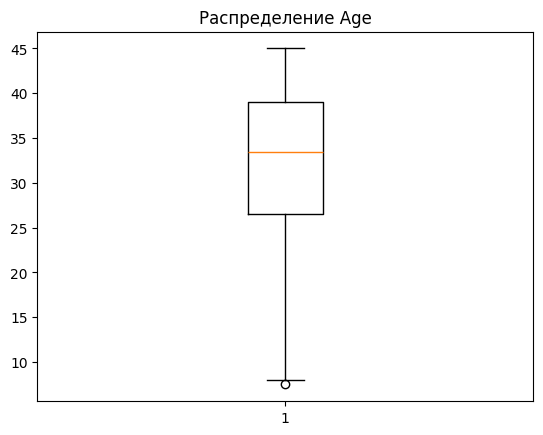

Кол-во выбросов: 1


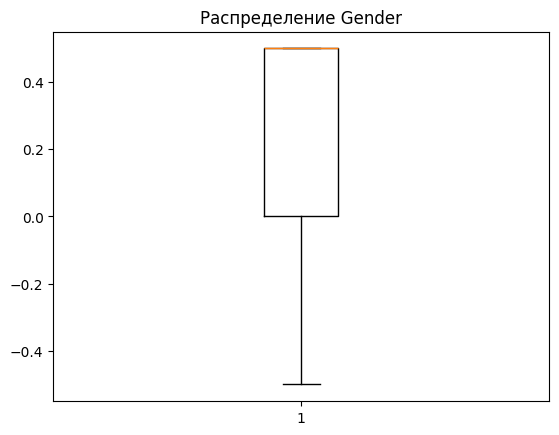

Кол-во выбросов: 0


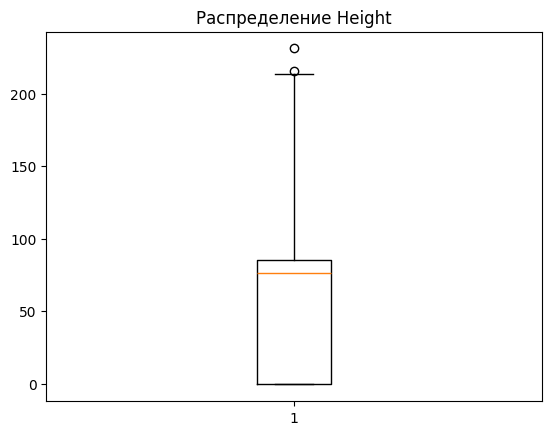

Кол-во выбросов: 2


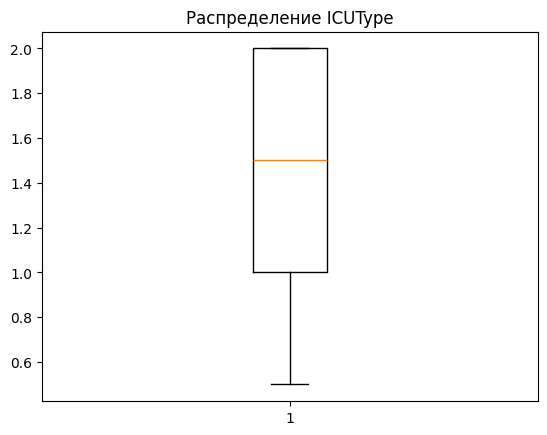

Кол-во выбросов: 0


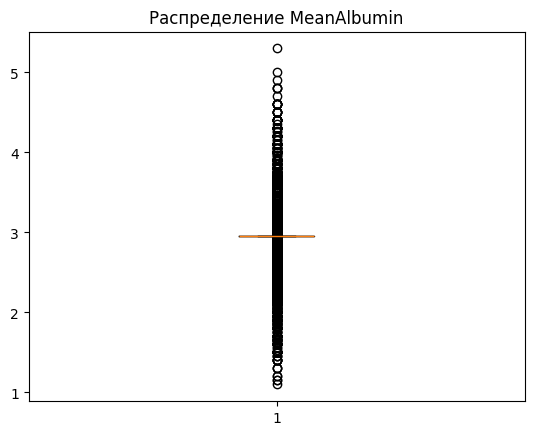

Кол-во выбросов: 8000


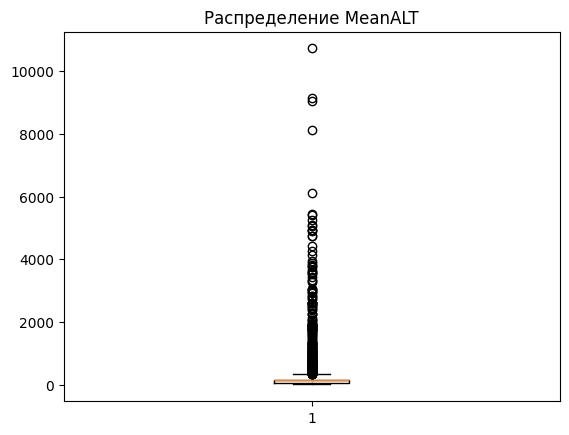

Кол-во выбросов: 250


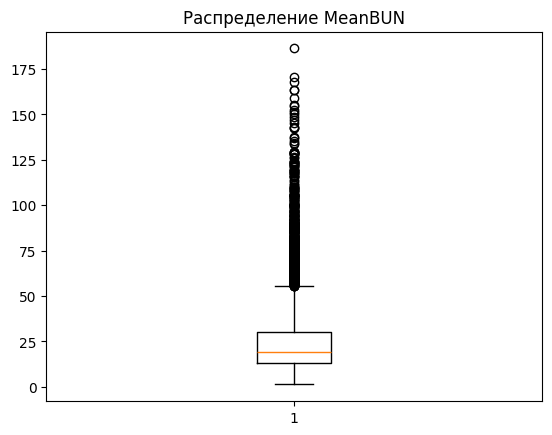

Кол-во выбросов: 655


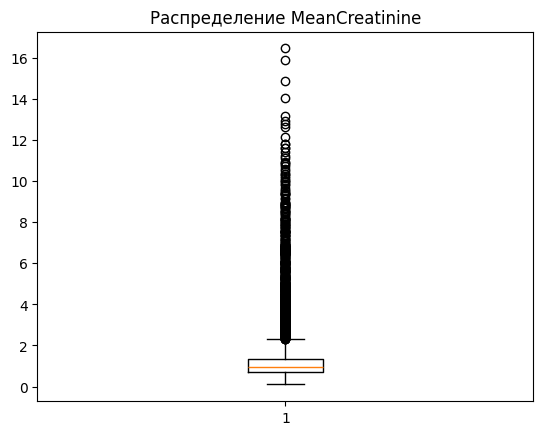

Кол-во выбросов: 853


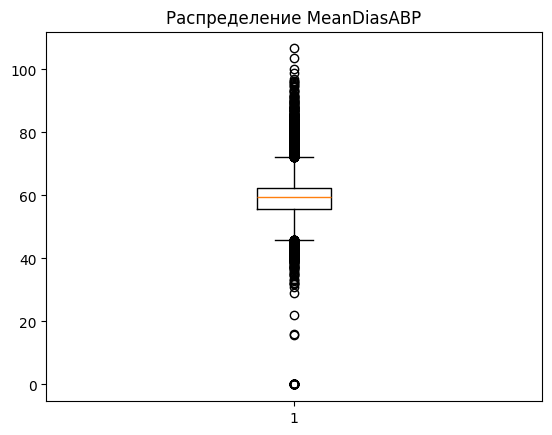

Кол-во выбросов: 886


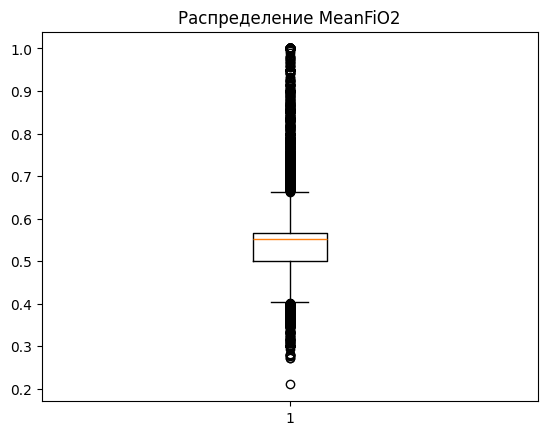

Кол-во выбросов: 1393


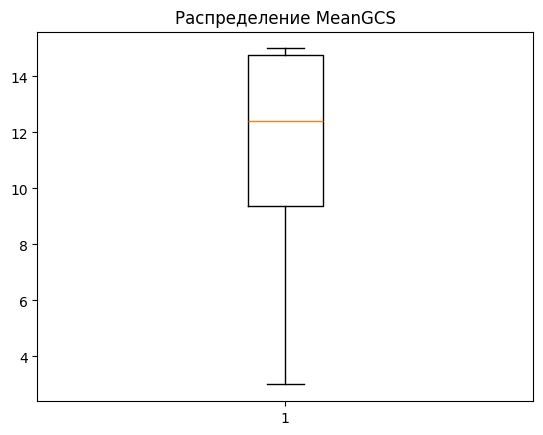

Кол-во выбросов: 0


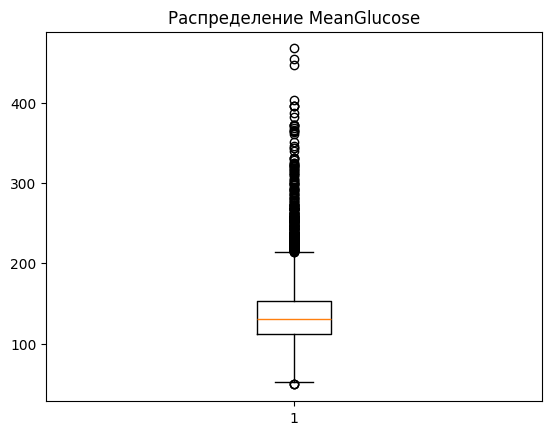

Кол-во выбросов: 367


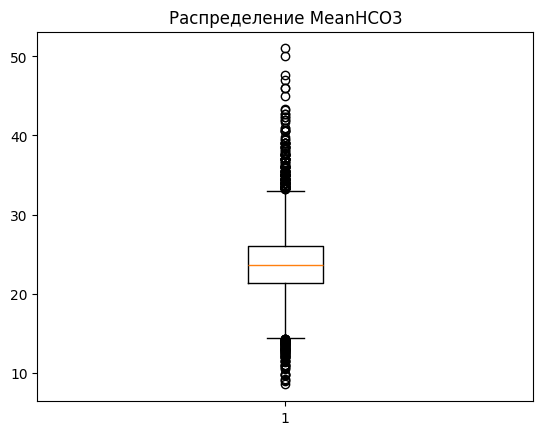

Кол-во выбросов: 253


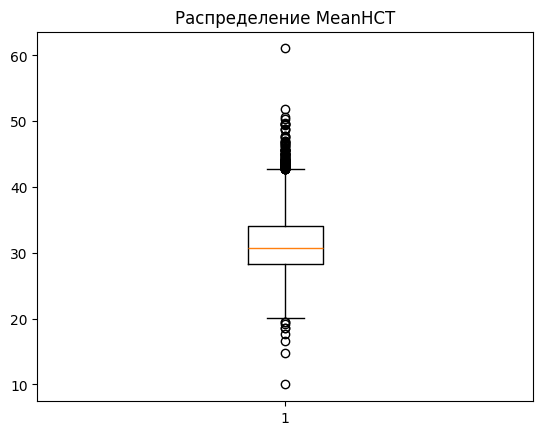

Кол-во выбросов: 127


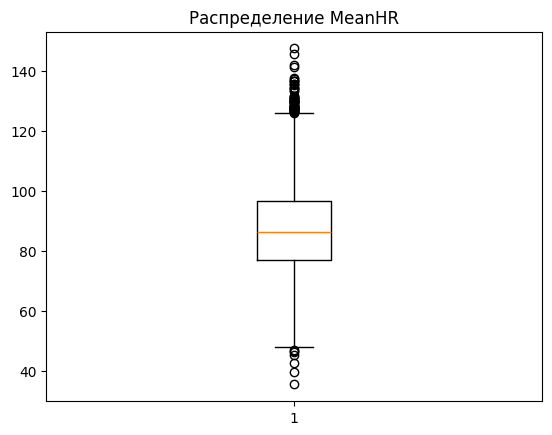

Кол-во выбросов: 63


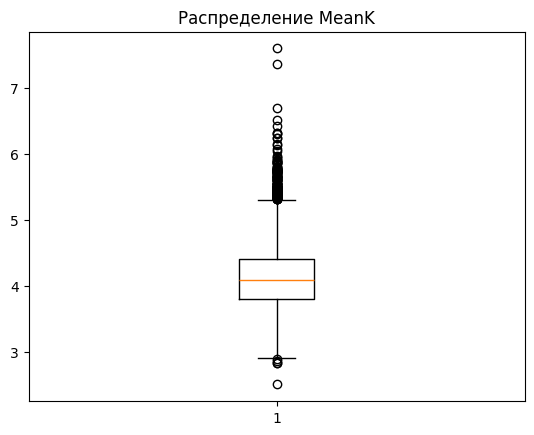

Кол-во выбросов: 183


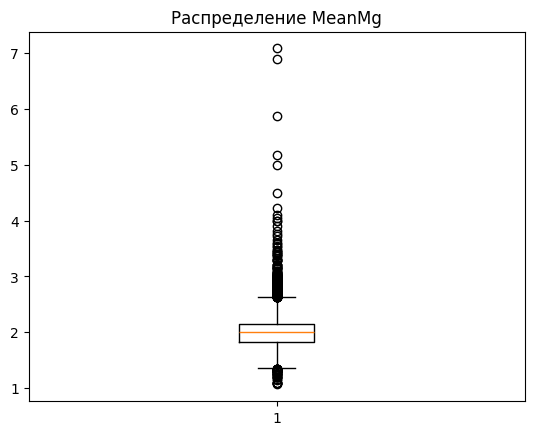

Кол-во выбросов: 329


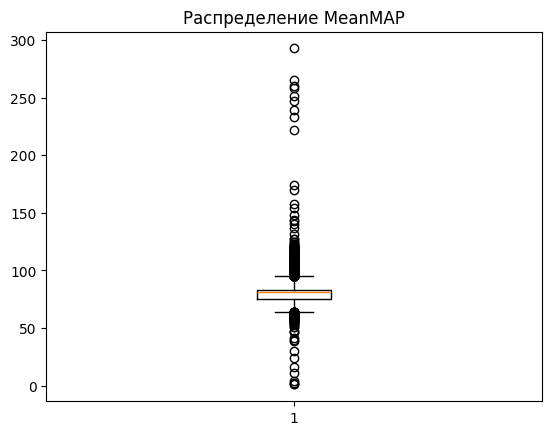

Кол-во выбросов: 802


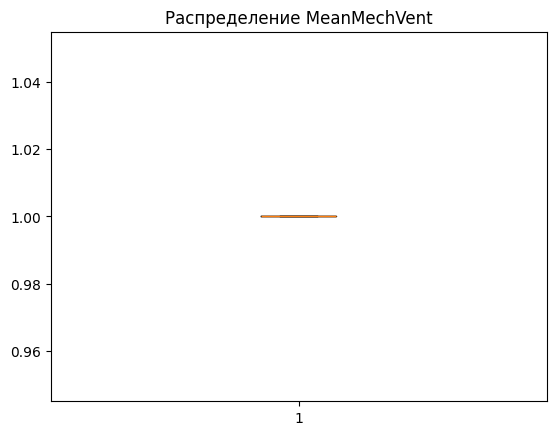

Кол-во выбросов: 8000


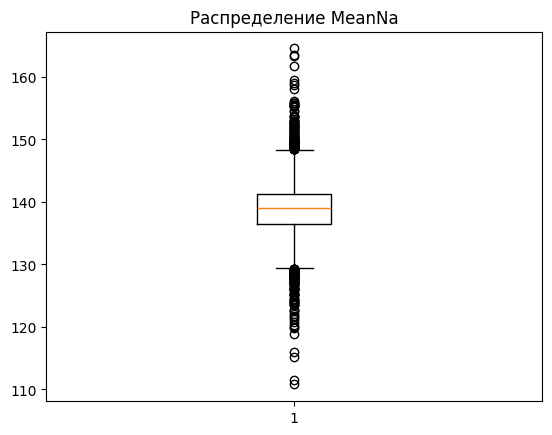

Кол-во выбросов: 235


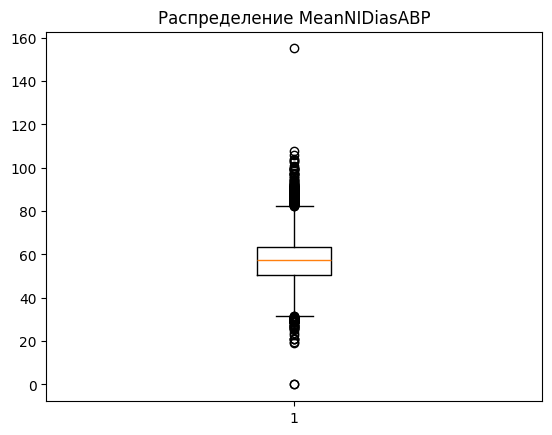

Кол-во выбросов: 259


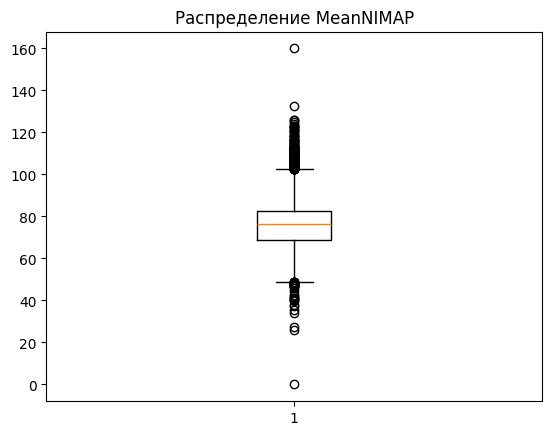

Кол-во выбросов: 244


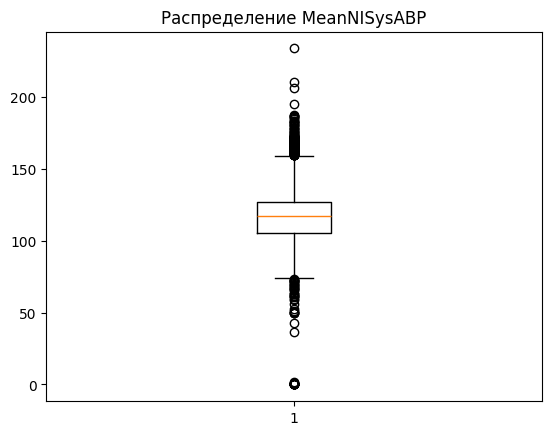

Кол-во выбросов: 228


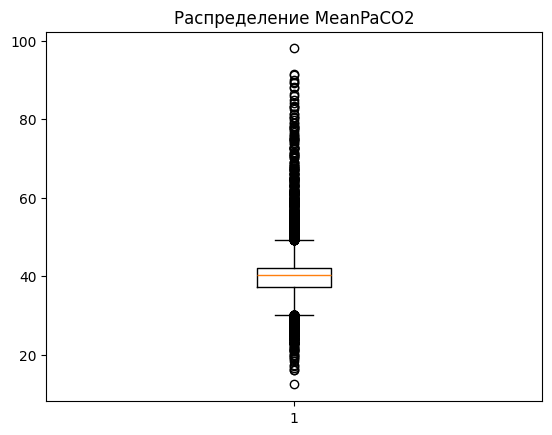

Кол-во выбросов: 866


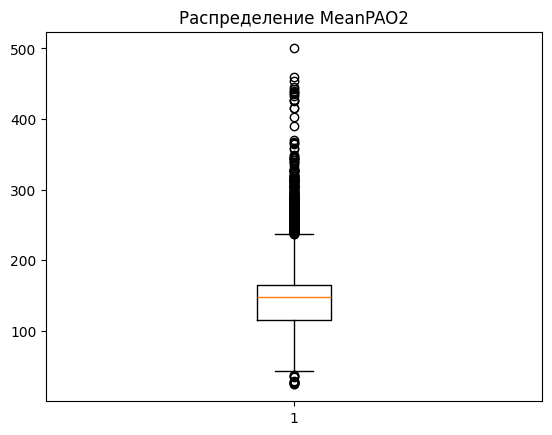

Кол-во выбросов: 443


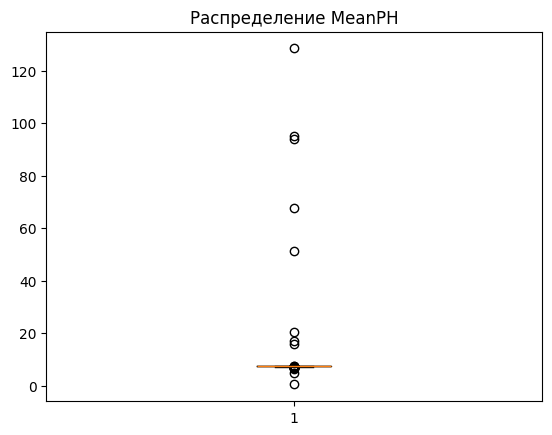

Кол-во выбросов: 85


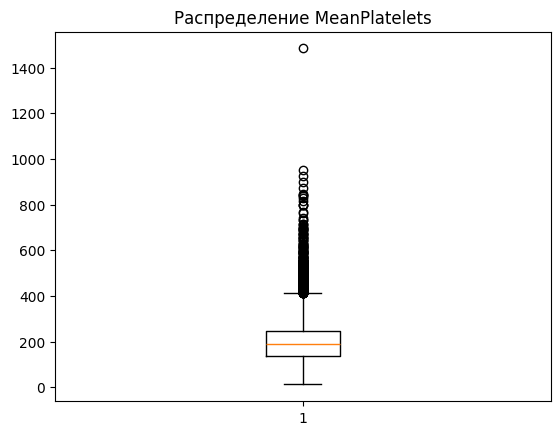

Кол-во выбросов: 320


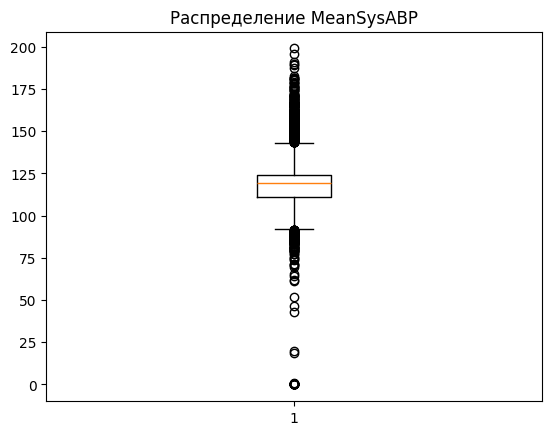

Кол-во выбросов: 738


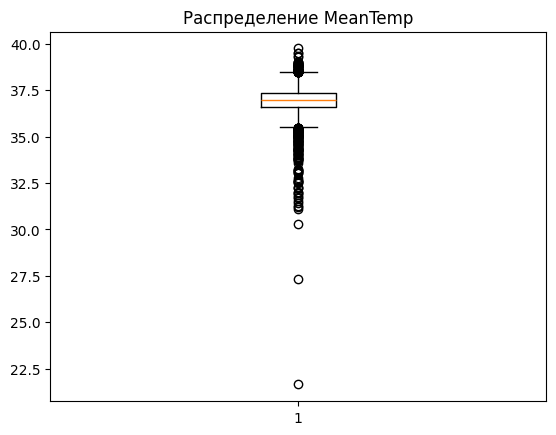

Кол-во выбросов: 195


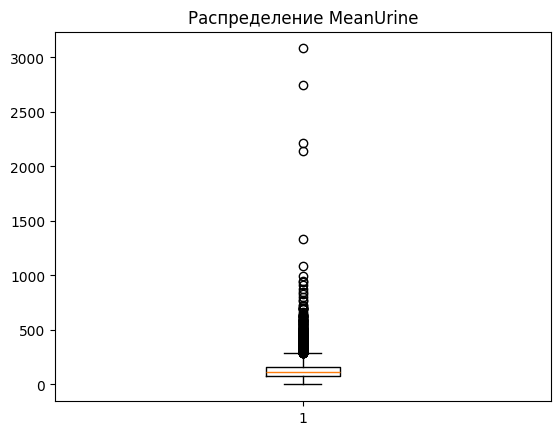

Кол-во выбросов: 453


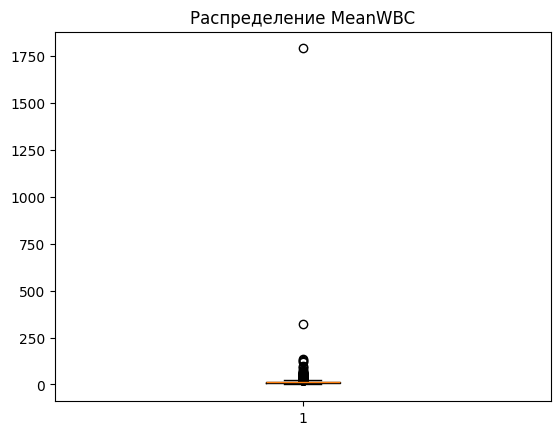

Кол-во выбросов: 306


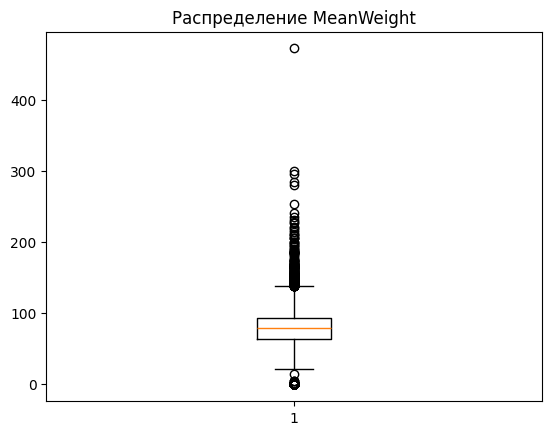

Кол-во выбросов: 825


In [17]:
dataset_cols = dataset.columns

cols_with_outliers = [] # колонки, где <= 300 выбросов (остальные колонки считаем нормальными такие значения)

for i in range(1, 33):
    col_name = dataset_cols[i]

    plt.boxplot(dataset[col_name])
    plt.title(f"Распределение {col_name}")
    plt.show()

    outliers_count = len(get_outliers(dataset[col_name]))

    if outliers_count <= 300:
        cols_with_outliers.append(col_name)

    print(f"Кол-во выбросов: {outliers_count}")

In [21]:
dataset.describe()

,RecordID,Age,Gender,Height,ICUType,MeanAlbumin,MeanALT,MeanBUN,MeanCreatinine,MeanDiasABP,...,MeanNISysABP,MeanPaCO2,MeanPAO2,MeanPH,MeanPlatelets,MeanSysABP,MeanTemp,MeanUrine,MeanWBC,MeanWeight
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,...,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,71336.304188,32.214875,0.280687,44.059113,1.391875,2.951625,161.229856,25.497301,1.348567,59.614996,...,117.545295,40.347935,147.385179,7.452670,204.157717,119.096129,36.956918,134.054444,12.797013,76.614612
std,2928.526287,8.676314,0.249131,43.102086,0.506548,0.403546,384.455298,20.330122,1.354034,8.921962,...,18.739702,6.817232,49.345466,2.115730,103.131323,16.732247,0.704009,108.629870,21.254923,32.504830
min,66269.500000,7.500000,-0.500000,-0.500000,0.500000,1.100000,3.000000,1.285714,0.100000,0.000000,...,0.000000,12.400000,24.000000,0.400000,12.166667,0.000000,21.644615,0.000000,0.075000,-1.000000
25%,68796.375000,26.500000,0.000000,-0.500000,1.000000,2.951625,38.000000,13.000000,0.700000,55.780061,...,105.822967,37.250000,115.571429,7.365000,137.000000,111.124452,36.608333,75.588889,8.800000,63.400000
50%,71337.000000,33.500000,0.500000,76.200000,1.500000,2.951625,161.229856,19.000000,0.933333,59.614996,...,117.545295,40.347935,147.385179,7.407208,188.666667,119.096129,36.958824,114.809581,11.600000,78.000000
75%,73868.750000,39.000000,0.500000,85.100000,2.000000,2.951625,161.229856,30.000000,1.350000,62.326296,...,127.285714,42.000000,164.366477,7.452670,247.000000,124.000000,37.352709,161.354620,14.868750,92.829021
max,76432.000000,45.000000,0.500000,231.150000,2.000000,5.300000,10728.888889,186.333333,16.457143,106.666667,...,234.000000,98.000000,500.000000,128.532500,1483.666667,199.000000,39.748980,3082.380952,1791.542857,472.000000


In [18]:
my_dataset = pd.read_csv("my_dataset.csv") # Для сравнения возмём мой собранный датасет

my_dataset.describe()

,Unnamed: 0,RecordID,Survival,In-hospital_death,Age,Gender,Height,ICUType,MeanAlbumin,MeanALP,...,MeanPlatelets,MeanRespRate,MeanSaO2,MeanSysABP,MeanTemp,MeanTropI,MeanTropT,MeanUrine,MeanWBC,MeanWeight
count,8000.00000,8000.000000,8000.000000,8000.000000,288.000000,288.000000,288.000000,288.000000,117.000000,113.000000,...,283.000000,75.000000,133.000000,214.000000,287.000000,0.0,0.0,284.000000,282.000000,288.000000
mean,3999.50000,142672.608375,130.426875,0.140250,64.173611,0.572917,90.060069,2.819444,2.973545,115.651794,...,193.440096,18.666927,96.704672,119.629160,36.955511,NaN,NaN,127.187251,19.182527,78.925927
std,2309.54541,5857.052574,364.766144,0.347268,16.938845,0.495516,85.482056,1.009728,0.642048,116.242252,...,80.031759,3.441008,3.299055,19.423985,0.685134,NaN,NaN,93.151379,106.090291,41.780222
min,0.00000,132539.000000,-23.000000,0.000000,16.000000,0.000000,-1.000000,1.000000,1.566667,36.000000,...,18.600000,13.153846,67.000000,0.000000,31.831250,NaN,NaN,1.045455,0.200000,-1.000000
25%,1999.75000,137592.750000,-1.000000,0.000000,52.750000,0.000000,-1.000000,2.000000,2.500000,60.500000,...,140.925000,16.347550,96.500000,108.678712,36.595833,NaN,NaN,72.638138,9.337500,62.188889
50%,3999.50000,142674.000000,-1.000000,0.000000,67.000000,1.000000,152.400000,3.000000,2.900000,83.000000,...,178.000000,17.575000,97.363636,117.199849,37.017241,NaN,NaN,109.775641,11.800000,77.850000
75%,5999.25000,147737.500000,17.000000,0.000000,77.250000,1.000000,170.200000,4.000000,3.500000,114.000000,...,242.000000,21.148181,98.000000,128.270492,37.343056,NaN,NaN,150.200431,15.237500,96.342500
max,7999.00000,152864.000000,2620.000000,1.000000,90.000000,1.000000,193.000000,4.000000,4.200000,763.000000,...,494.666667,30.176471,99.000000,182.907692,38.554545,NaN,NaN,691.818182,1791.542857,472.000000


Вывод: в данных есть некоторые странности, например: рост у многих пациентов до 100 см (что вряд ли возможно); вес = -1 (что также не может быть); температура тела = 21 градус. Так что нужно удалить эти выбросы, чтобы не портить данные (удалять будем не все выбросы, а только те, где выбросов не больше 300).

In [19]:
outliers_indexes = []

for col in cols_with_outliers:
    col_outliers = get_outliers(dataset[col])
    outliers_indexes = outliers_indexes + list(col_outliers)

outliers_indexes = list(set(outliers_indexes))

In [24]:
print("Кол-во строк с выбросами:", len(outliers_indexes))

Кол-во строк с выбросами: 1564


In [20]:
dataset.drop(index=outliers_indexes, inplace=True)

In [21]:
dataset[["Survival", "In-hospital_death"]] = outcomes[["Survival", "In-hospital_death"]]

In [27]:
dataset

,RecordID,Age,Gender,Height,ICUType,MeanAlbumin,MeanALT,MeanBUN,MeanCreatinine,MeanDiasABP,...,MeanPAO2,MeanPH,MeanPlatelets,MeanSysABP,MeanTemp,MeanUrine,MeanWBC,MeanWeight,Survival,In-hospital_death
0,66269.5,27.0,0.0,-0.50,2.0,2.951625,161.229856,10.500000,0.750000,59.614996,...,147.385179,7.452670,203.000000,119.096129,37.357143,171.052632,10.300000,-1.000000,-1,0
1,66270.0,38.0,0.5,87.65,1.0,2.951625,161.229856,18.333333,1.100000,58.897059,...,210.142857,7.395000,178.600000,113.411765,36.939130,151.560976,11.266667,80.670588,-1,0
2,66270.5,22.0,0.0,-0.50,1.5,2.500000,83.000000,4.666667,0.333333,67.125000,...,134.500000,7.495000,89.666667,125.687500,37.800000,124.951220,4.700000,56.700000,-1,0
3,66271.5,34.0,0.5,90.15,1.5,4.400000,12.000000,17.666667,0.766667,59.614996,...,147.385179,7.452670,330.000000,119.096129,36.223077,545.833333,9.400000,84.600000,575,0
4,66272.5,44.0,0.0,-0.50,1.5,3.300000,161.229856,35.000000,1.000000,59.614996,...,147.385179,7.452670,103.000000,119.096129,36.880000,62.131579,4.300000,-1.000000,918,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7994,76424.0,32.0,0.0,-0.50,2.0,2.951625,161.229856,23.000000,1.050000,61.787234,...,121.285714,7.411429,112.500000,143.638298,37.166667,142.777778,14.250000,81.189189,2210,0
7995,76424.5,39.0,0.5,90.15,1.0,2.951625,161.229856,24.000000,1.000000,62.355932,...,159.250000,7.375625,118.250000,129.271186,36.854348,129.487805,16.766667,88.184444,752,0
7996,76425.5,45.0,0.5,88.90,1.5,2.951625,12.000000,54.571429,2.157143,45.375000,...,77.333333,7.276667,278.428571,117.416667,37.092857,20.333333,28.071429,87.096000,39,0
7997,76429.0,35.0,0.0,76.20,1.0,2.800000,11.000000,29.666667,1.600000,60.863636,...,117.500000,7.350000,189.333333,120.272727,36.600000,135.926829,14.333333,78.090566,334,0


## Описательная статистика

In [22]:
dataset.describe()

,RecordID,Age,Gender,Height,ICUType,MeanAlbumin,MeanALT,MeanBUN,MeanCreatinine,MeanDiasABP,...,MeanPAO2,MeanPH,MeanPlatelets,MeanSysABP,MeanTemp,MeanUrine,MeanWBC,MeanWeight,Survival,In-hospital_death
count,6436.000000,6436.000000,6436.000000,6436.000000,6436.000000,6436.000000,6436.000000,6436.000000,6436.000000,6436.000000,...,6436.000000,6436.000000,6436.000000,6436.000000,6436.000000,6436.000000,6436.000000,6436.000000,6436.000000,6436.000000
mean,71330.163145,32.565491,0.282163,45.407093,1.377175,2.956548,117.222358,23.932084,1.243989,59.233313,...,149.541739,7.404066,204.041672,118.607355,37.005648,135.295032,12.516872,76.093252,132.649627,0.121038
std,2934.036236,8.567477,0.248880,42.843342,0.514235,0.389243,65.695199,18.712047,1.180542,8.456571,...,49.893684,0.051651,99.800603,15.959864,0.524136,99.740996,7.568831,31.920974,370.930824,0.326197
min,66269.500000,8.000000,-0.500000,-0.500000,0.500000,1.100000,3.000000,1.700000,0.100000,0.000000,...,25.000000,7.235333,13.666667,0.000000,35.492593,0.000000,0.100000,-1.000000,-23.000000,0.000000
25%,68796.875000,27.000000,0.000000,-0.500000,1.000000,2.951625,37.875000,12.666667,0.700000,55.464156,...,118.000000,7.370000,138.750000,110.774397,36.645202,78.268499,8.872917,63.481696,-1.000000,0.000000
50%,71319.250000,34.000000,0.500000,76.200000,1.500000,2.951625,161.229856,18.333333,0.900000,59.614996,...,147.385179,7.410000,188.416667,119.096129,36.977033,116.292313,11.600000,78.095283,-1.000000,0.000000
75%,73885.875000,39.500000,0.500000,85.750000,2.000000,2.951625,161.229856,28.000000,1.300000,61.746591,...,167.143750,7.452670,245.062500,123.287972,37.358456,161.343054,14.750000,92.241268,15.000000,0.000000
max,76431.000000,45.000000,0.500000,203.200000,2.000000,5.300000,346.000000,186.333333,15.875000,106.666667,...,500.000000,7.576250,950.750000,199.000000,38.463158,2215.454545,323.710000,472.000000,2620.000000,1.000000


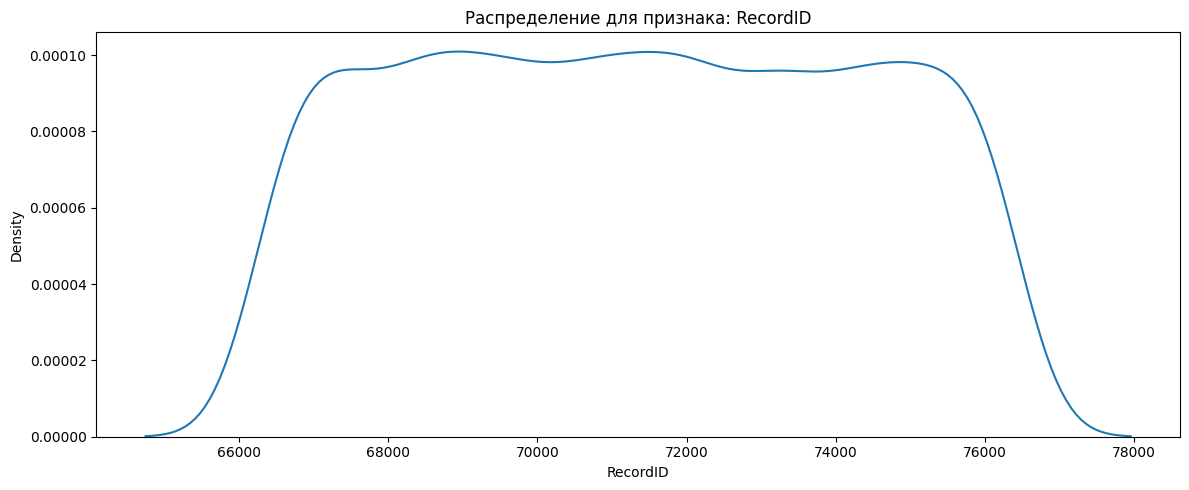

По тесту Шапиро нормальность распределения RecordID: False, p_value: 1.7032841341160075e-40
Скошенность распределения RecordID: Не выявлено


c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6436.
  res = hypotest_fun_out(*samples, **kwds)


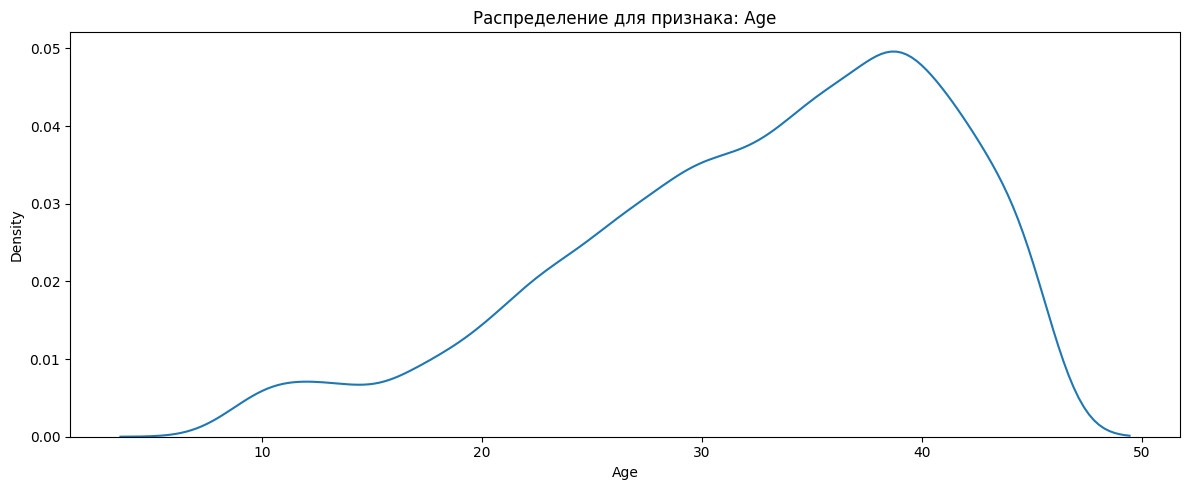

c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6436.
  res = hypotest_fun_out(*samples, **kwds)


По тесту Шапиро нормальность распределения Age: False, p_value: 1.0327915539358414e-41
Скошенность распределения Age: Вправо


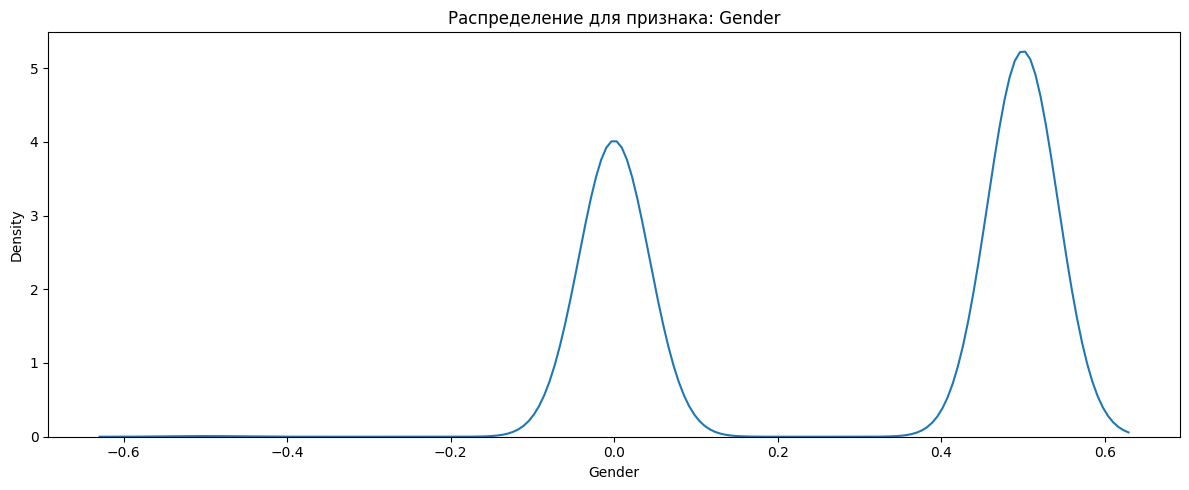

По тесту Шапиро нормальность распределения Gender: False, p_value: 2.436579036391503e-79
Скошенность распределения Gender: Вправо


c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6436.
  res = hypotest_fun_out(*samples, **kwds)


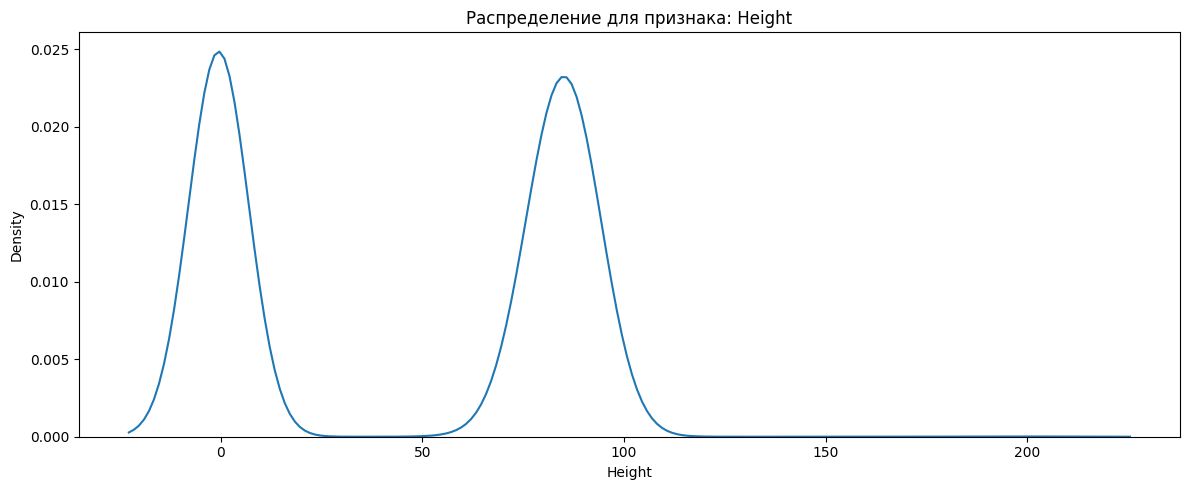

c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6436.
  res = hypotest_fun_out(*samples, **kwds)


По тесту Шапиро нормальность распределения Height: False, p_value: 2.223968122395493e-75
Скошенность распределения Height: Вправо


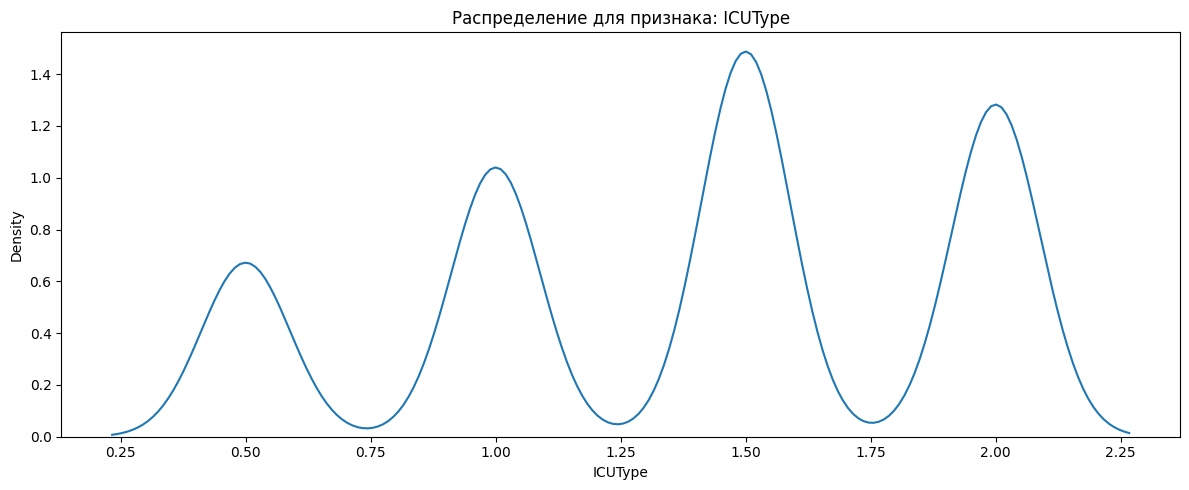

c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6436.
  res = hypotest_fun_out(*samples, **kwds)


По тесту Шапиро нормальность распределения ICUType: False, p_value: 9.251017883479239e-60
Скошенность распределения ICUType: Вправо


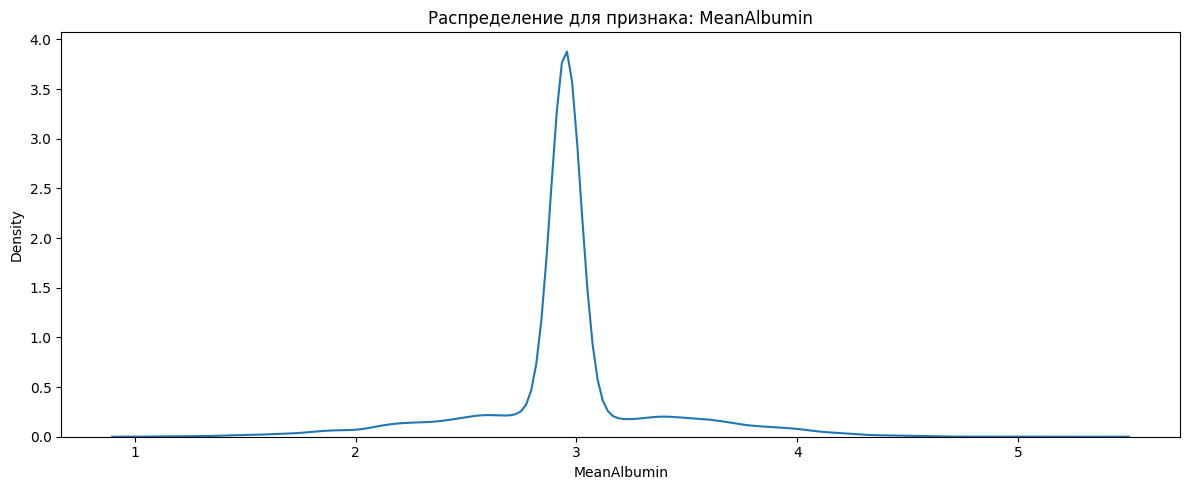

c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6436.
  res = hypotest_fun_out(*samples, **kwds)


По тесту Шапиро нормальность распределения MeanAlbumin: False, p_value: 8.82204326965717e-69
Скошенность распределения MeanAlbumin: Не выявлено


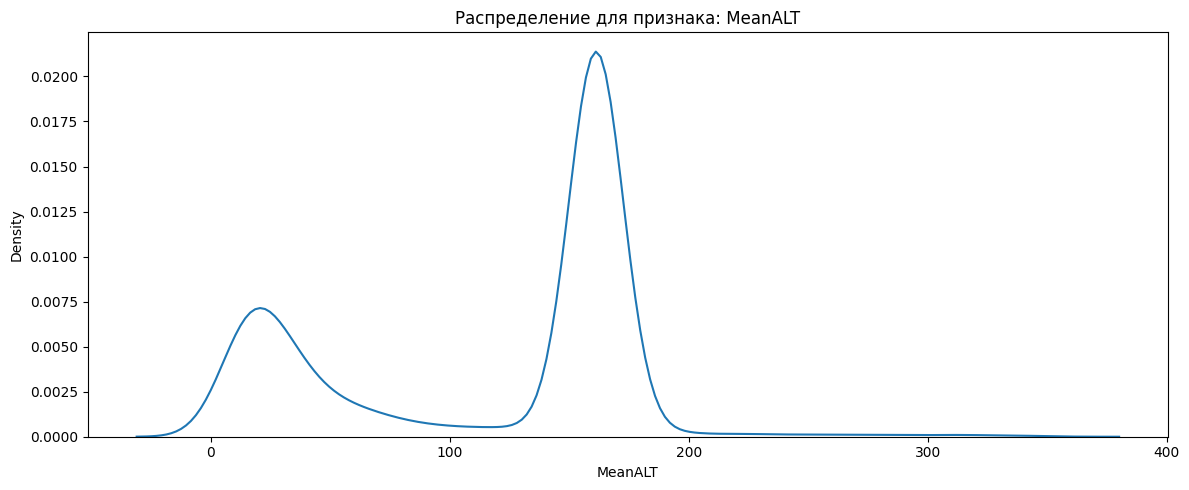

c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6436.
  res = hypotest_fun_out(*samples, **kwds)


По тесту Шапиро нормальность распределения MeanALT: False, p_value: 9.051809324706699e-73
Скошенность распределения MeanALT: Вправо


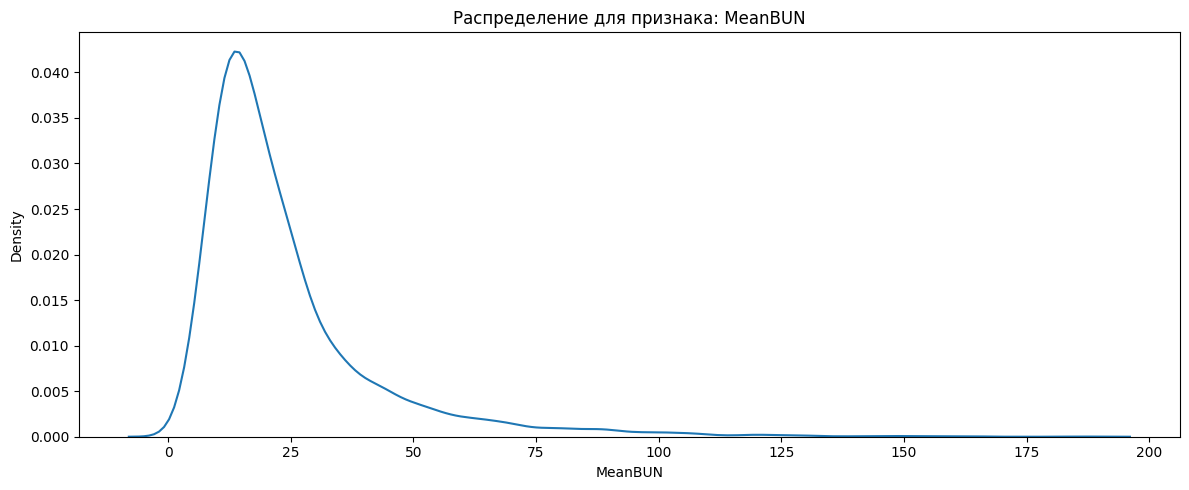

c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6436.
  res = hypotest_fun_out(*samples, **kwds)


По тесту Шапиро нормальность распределения MeanBUN: False, p_value: 1.6235896145240136e-71
Скошенность распределения MeanBUN: Влево


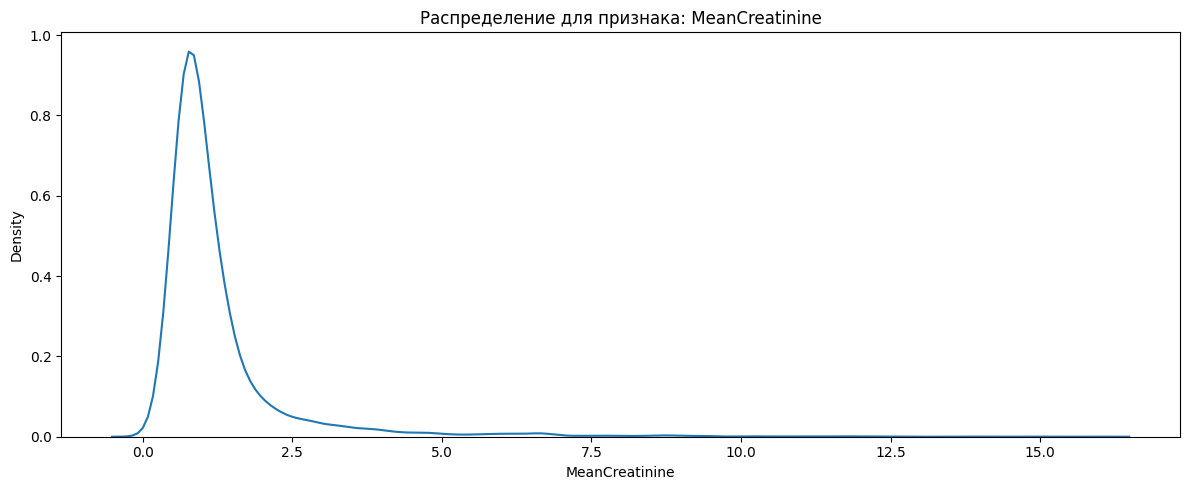

c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6436.
  res = hypotest_fun_out(*samples, **kwds)


По тесту Шапиро нормальность распределения MeanCreatinine: False, p_value: 6.15955827524071e-84
Скошенность распределения MeanCreatinine: Влево


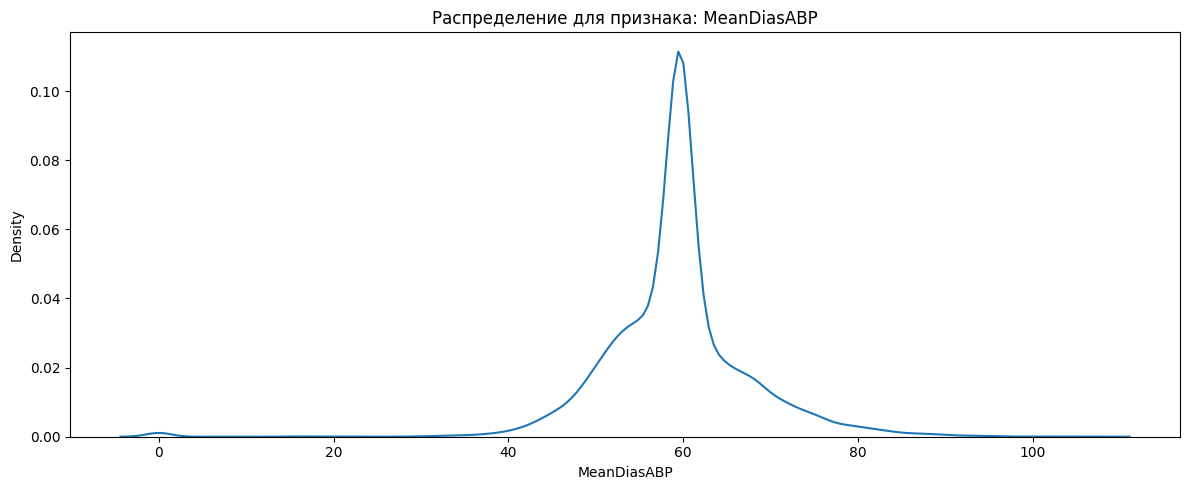

c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6436.
  res = hypotest_fun_out(*samples, **kwds)


По тесту Шапиро нормальность распределения MeanDiasABP: False, p_value: 4.27828729983699e-59
Скошенность распределения MeanDiasABP: Вправо


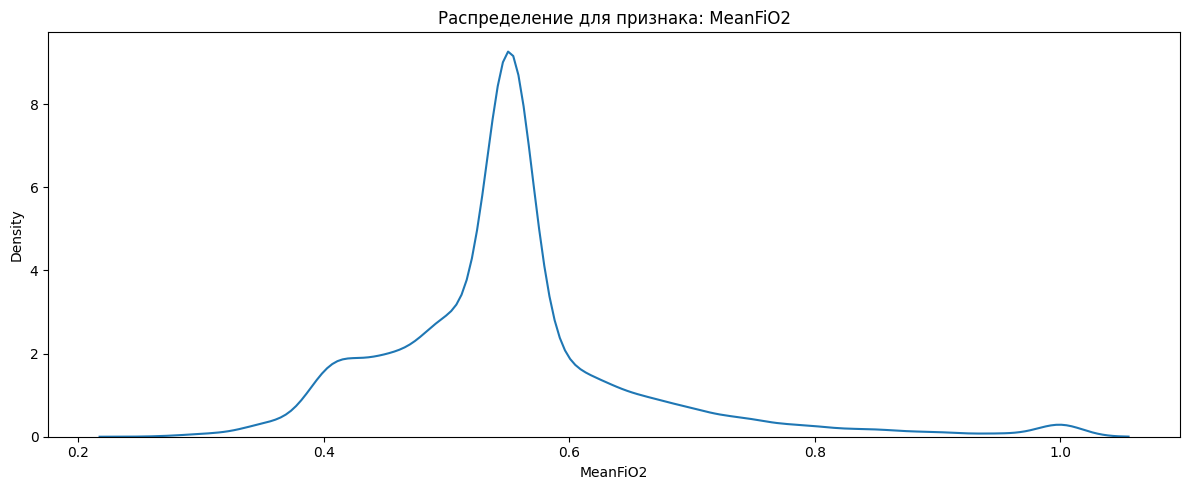

c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6436.
  res = hypotest_fun_out(*samples, **kwds)


По тесту Шапиро нормальность распределения MeanFiO2: False, p_value: 9.477477526354104e-60
Скошенность распределения MeanFiO2: Влево


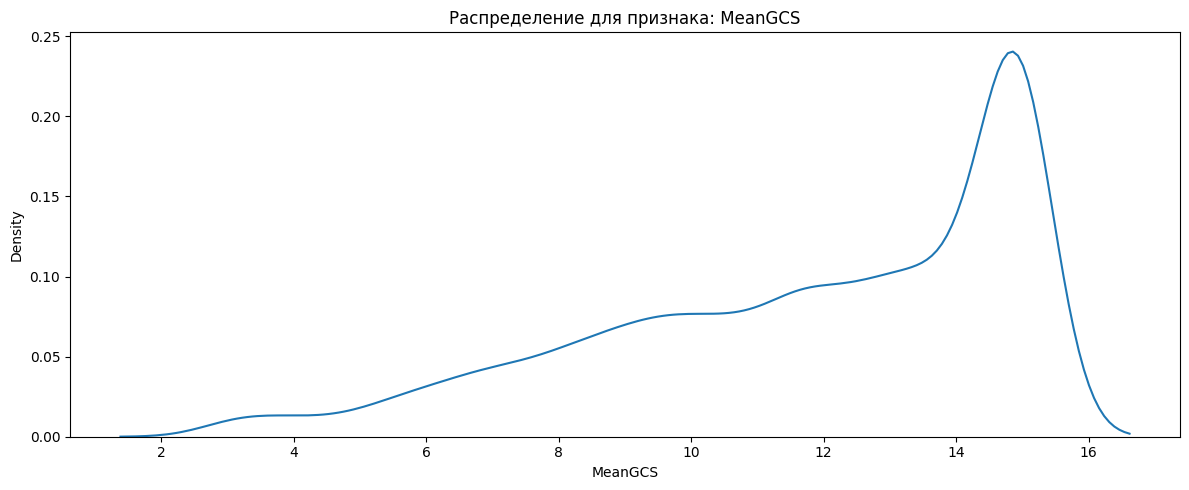

c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6436.
  res = hypotest_fun_out(*samples, **kwds)


По тесту Шапиро нормальность распределения MeanGCS: False, p_value: 1.309736591422379e-55
Скошенность распределения MeanGCS: Вправо


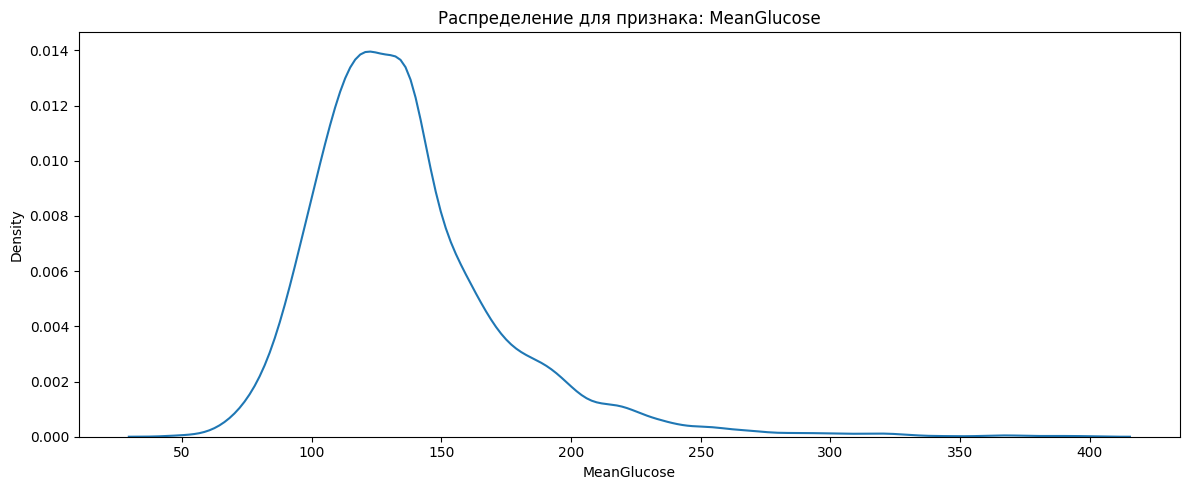

c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6436.
  res = hypotest_fun_out(*samples, **kwds)


По тесту Шапиро нормальность распределения MeanGlucose: False, p_value: 3.3194156688642626e-55
Скошенность распределения MeanGlucose: Влево


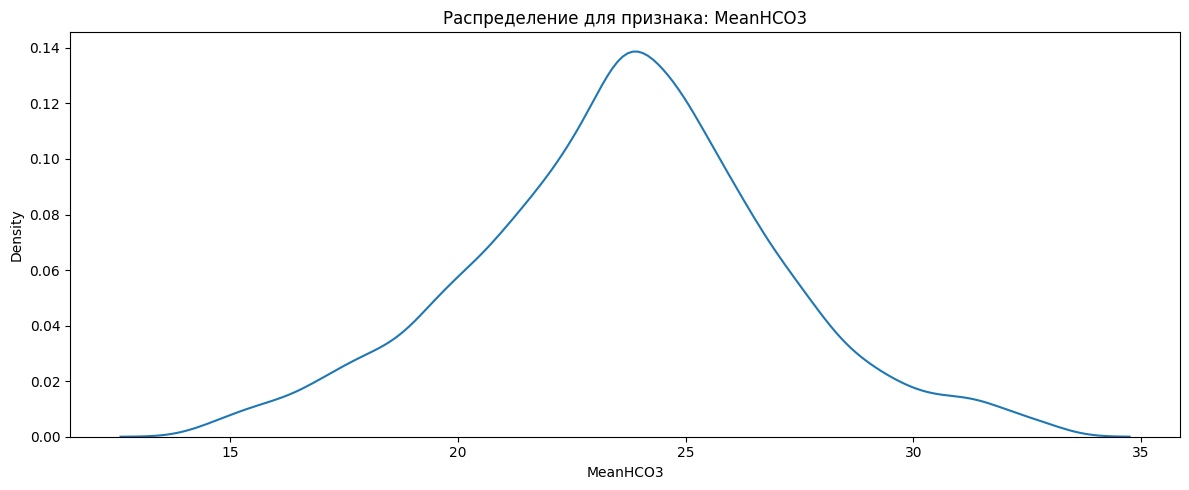

c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6436.
  res = hypotest_fun_out(*samples, **kwds)


По тесту Шапиро нормальность распределения MeanHCO3: False, p_value: 2.088777234841024e-14
Скошенность распределения MeanHCO3: Не выявлено


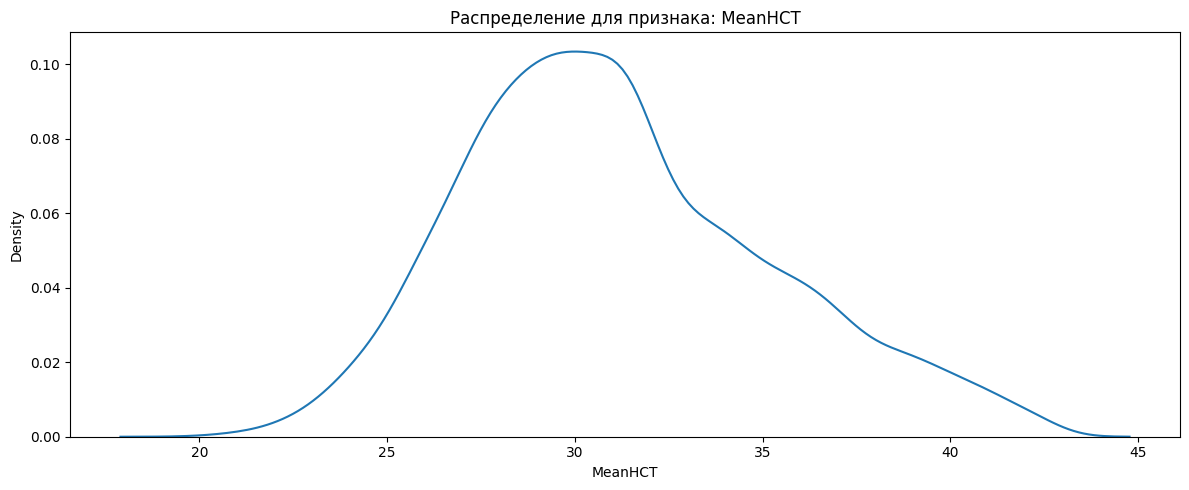

c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6436.
  res = hypotest_fun_out(*samples, **kwds)


По тесту Шапиро нормальность распределения MeanHCT: False, p_value: 4.533613318949175e-29
Скошенность распределения MeanHCT: Влево


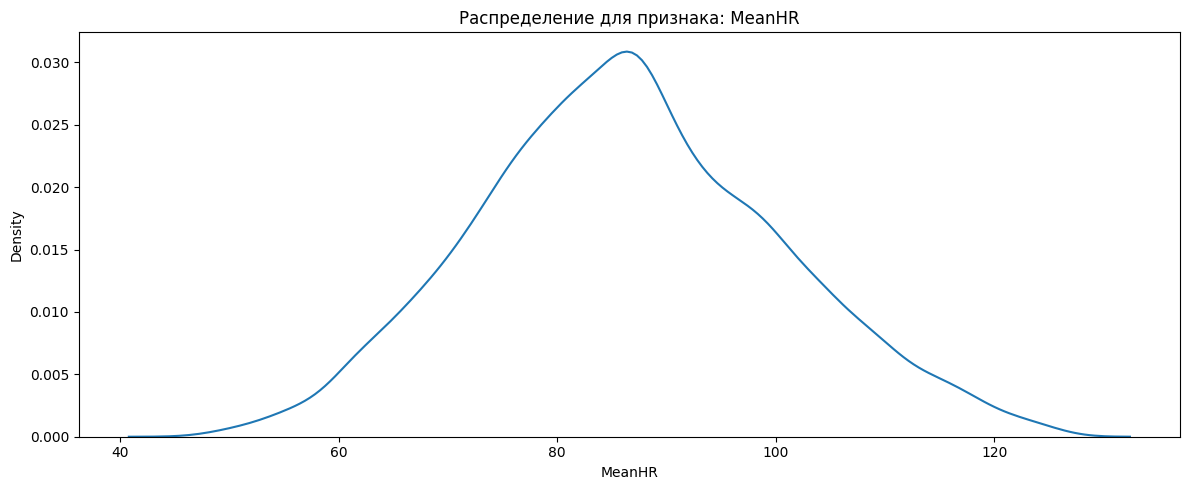

c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6436.
  res = hypotest_fun_out(*samples, **kwds)


По тесту Шапиро нормальность распределения MeanHR: False, p_value: 1.3765993545946786e-11
Скошенность распределения MeanHR: Влево


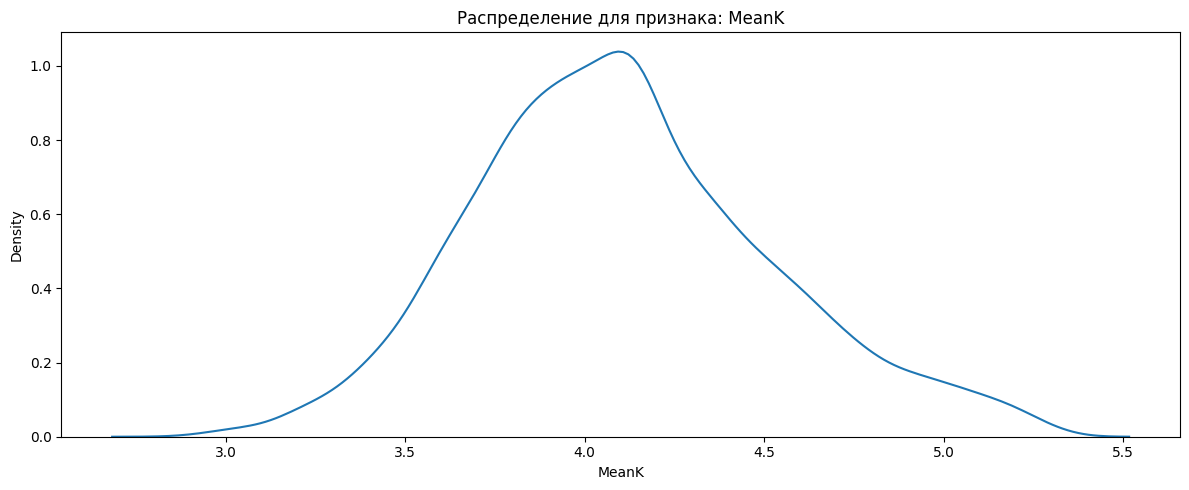

c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6436.
  res = hypotest_fun_out(*samples, **kwds)


По тесту Шапиро нормальность распределения MeanK: False, p_value: 6.212299253146726e-21
Скошенность распределения MeanK: Влево


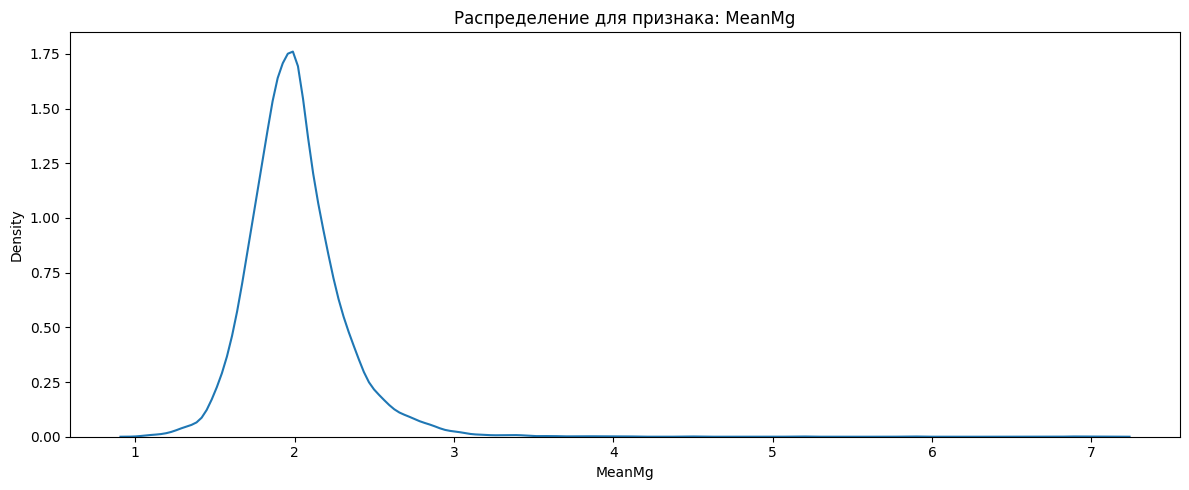

c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6436.
  res = hypotest_fun_out(*samples, **kwds)


По тесту Шапиро нормальность распределения MeanMg: False, p_value: 5.826918673891641e-58
Скошенность распределения MeanMg: Влево


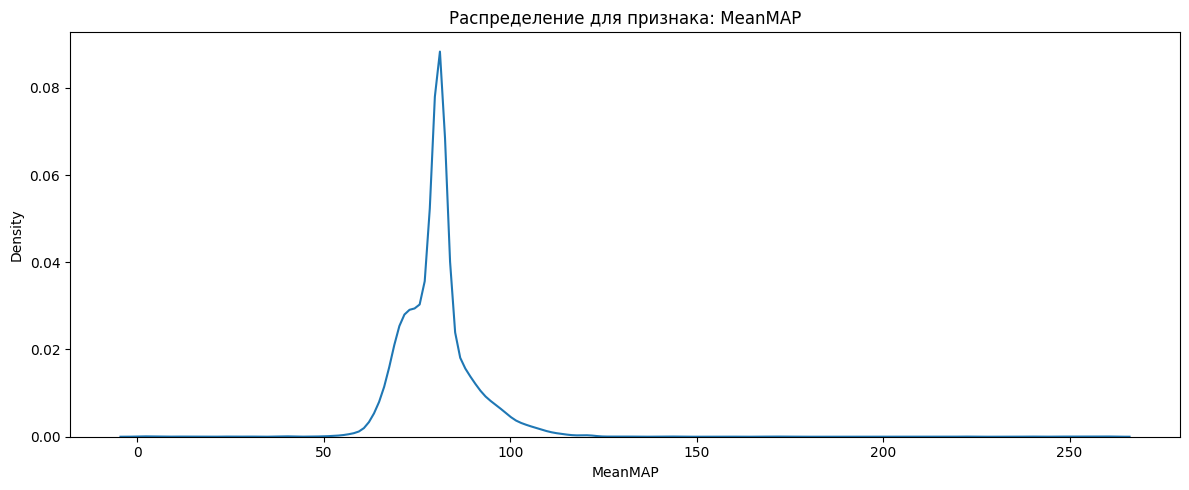

По тесту Шапиро нормальность распределения MeanMAP: False, p_value: 1.1170920425638127e-70
Скошенность распределения MeanMAP: Влево


c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6436.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Руслан\AppData\Local\Temp\ipykernel_30040\205664500.py:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x=column, ax=ax)


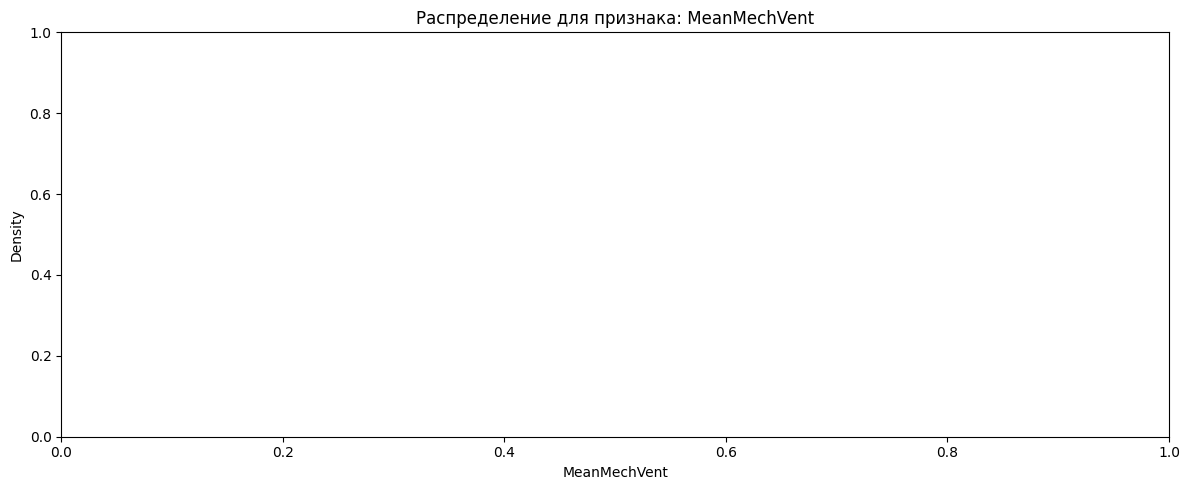

По тесту Шапиро нормальность распределения MeanMechVent: True, p_value: 1.0
Скошенность распределения MeanMechVent: Не выявлено


c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6436.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Руслан\AppData\Local\Temp\ipykernel_30040\205664500.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  result = skew(data)


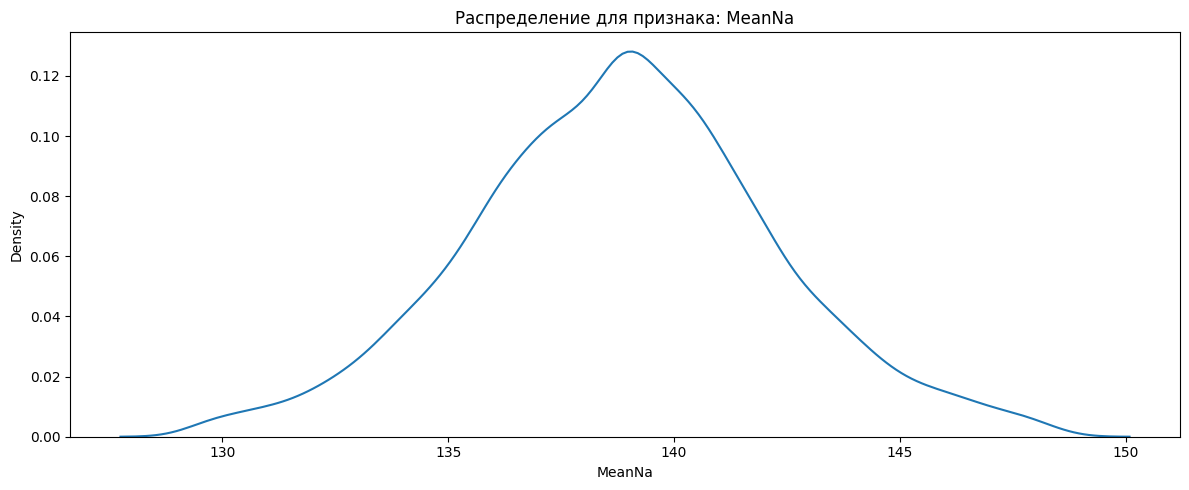

c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6436.
  res = hypotest_fun_out(*samples, **kwds)


По тесту Шапиро нормальность распределения MeanNa: False, p_value: 2.391869772785869e-09
Скошенность распределения MeanNa: Не выявлено


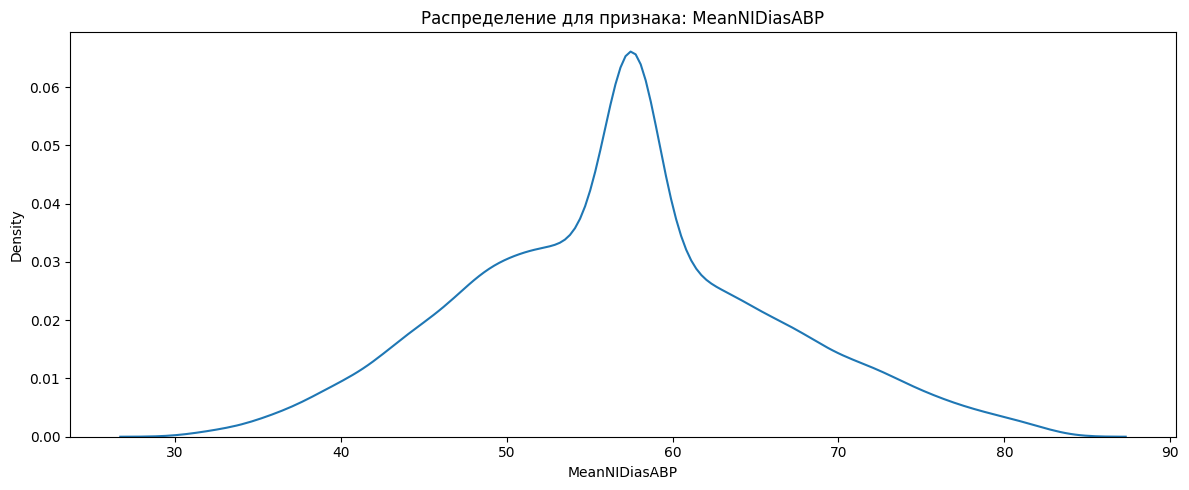

c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6436.
  res = hypotest_fun_out(*samples, **kwds)


По тесту Шапиро нормальность распределения MeanNIDiasABP: False, p_value: 3.33684752664724e-20
Скошенность распределения MeanNIDiasABP: Влево


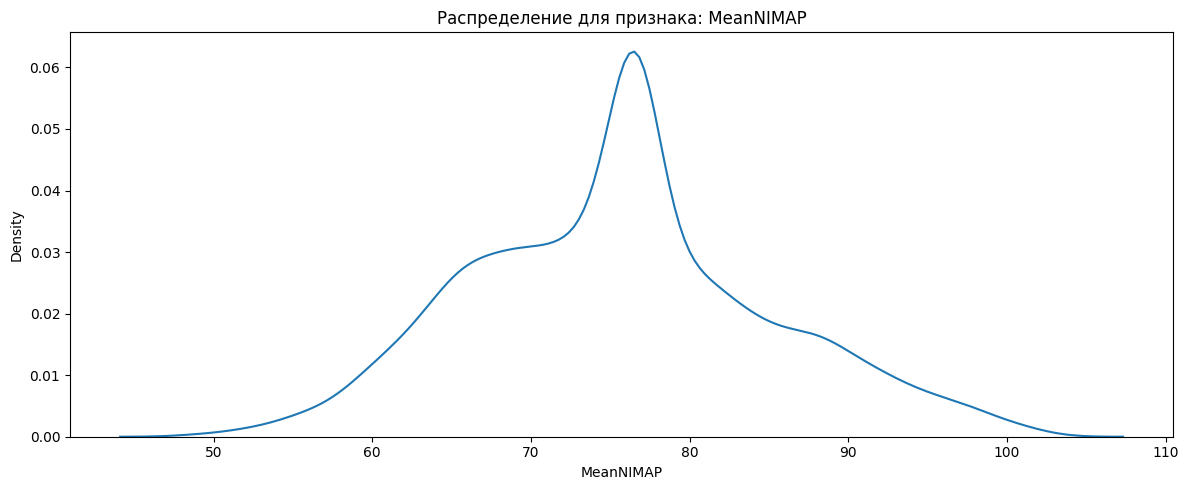

c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6436.
  res = hypotest_fun_out(*samples, **kwds)


По тесту Шапиро нормальность распределения MeanNIMAP: False, p_value: 4.841948558537786e-21
Скошенность распределения MeanNIMAP: Влево


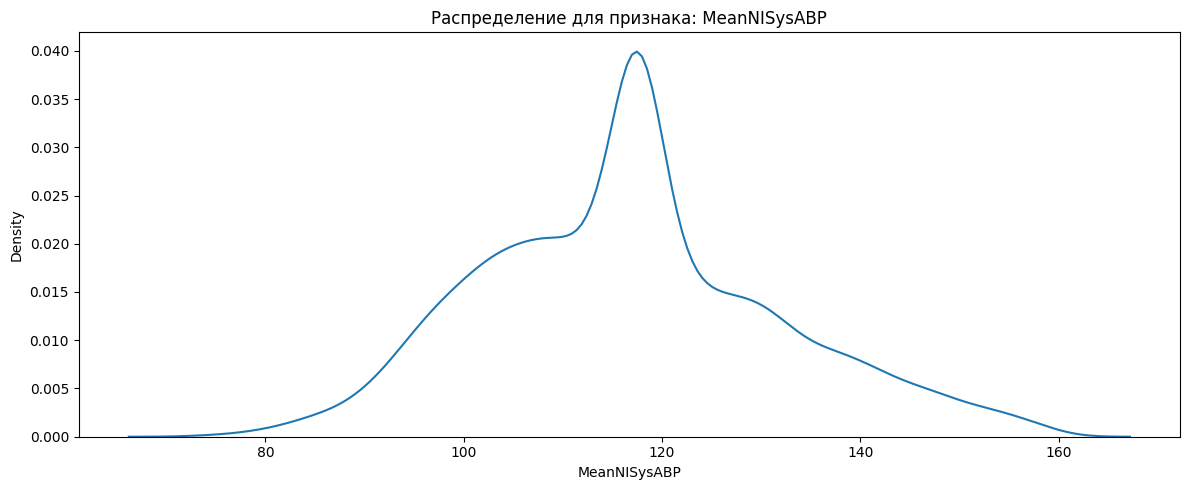

c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6436.
  res = hypotest_fun_out(*samples, **kwds)


По тесту Шапиро нормальность распределения MeanNISysABP: False, p_value: 3.0944475362018293e-24
Скошенность распределения MeanNISysABP: Влево


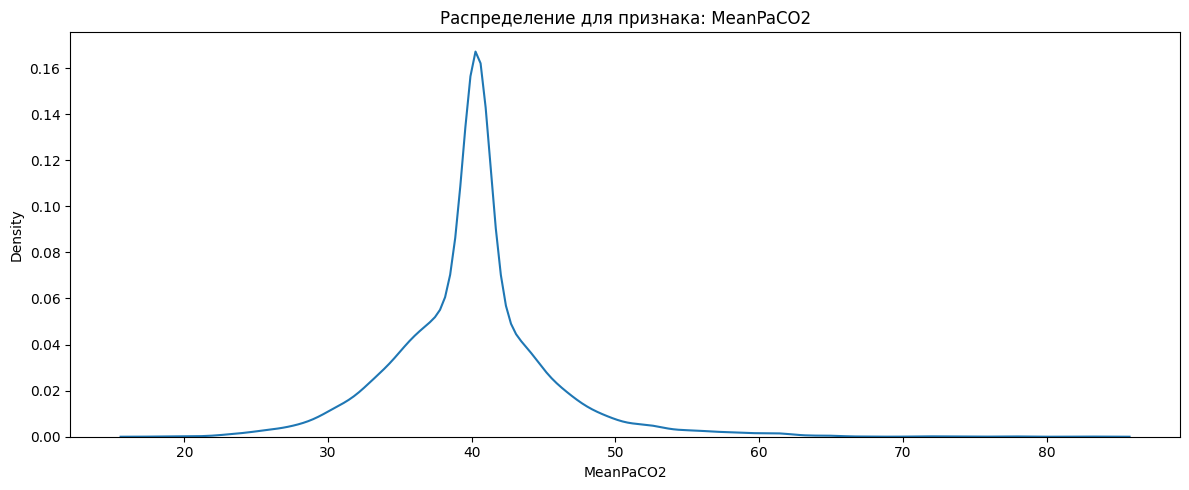

c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6436.
  res = hypotest_fun_out(*samples, **kwds)


По тесту Шапиро нормальность распределения MeanPaCO2: False, p_value: 1.769490424446667e-50
Скошенность распределения MeanPaCO2: Влево


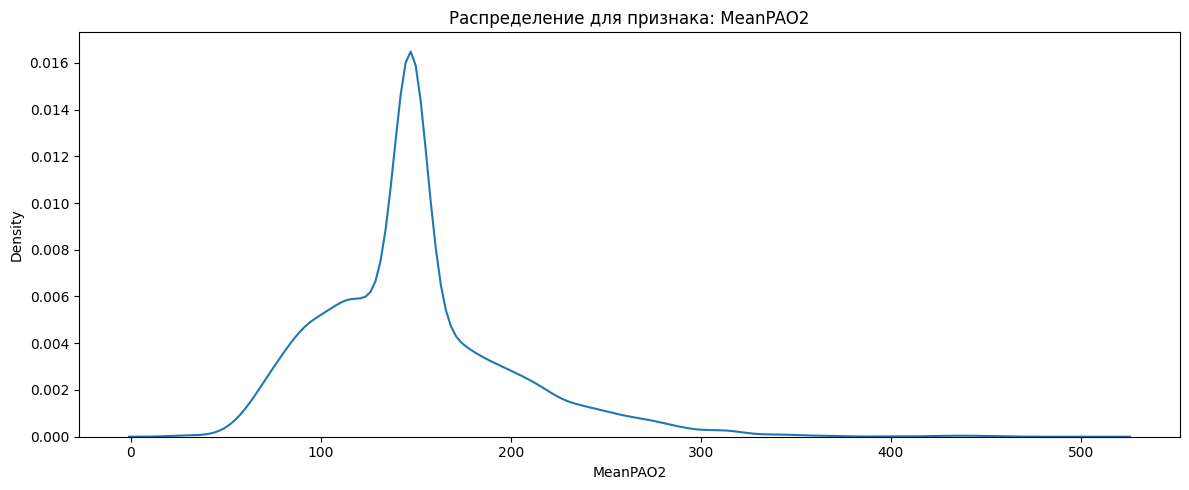

По тесту Шапиро нормальность распределения MeanPAO2: False, p_value: 4.103272635351787e-50
Скошенность распределения MeanPAO2: Влево


c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6436.
  res = hypotest_fun_out(*samples, **kwds)


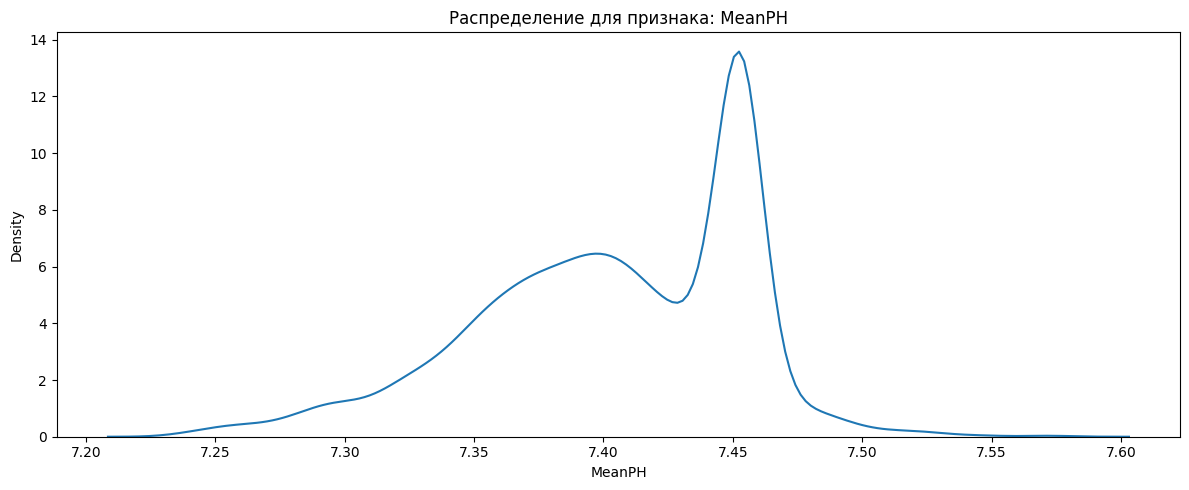

c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6436.
  res = hypotest_fun_out(*samples, **kwds)


По тесту Шапиро нормальность распределения MeanPH: False, p_value: 8.40576653109478e-44
Скошенность распределения MeanPH: Вправо


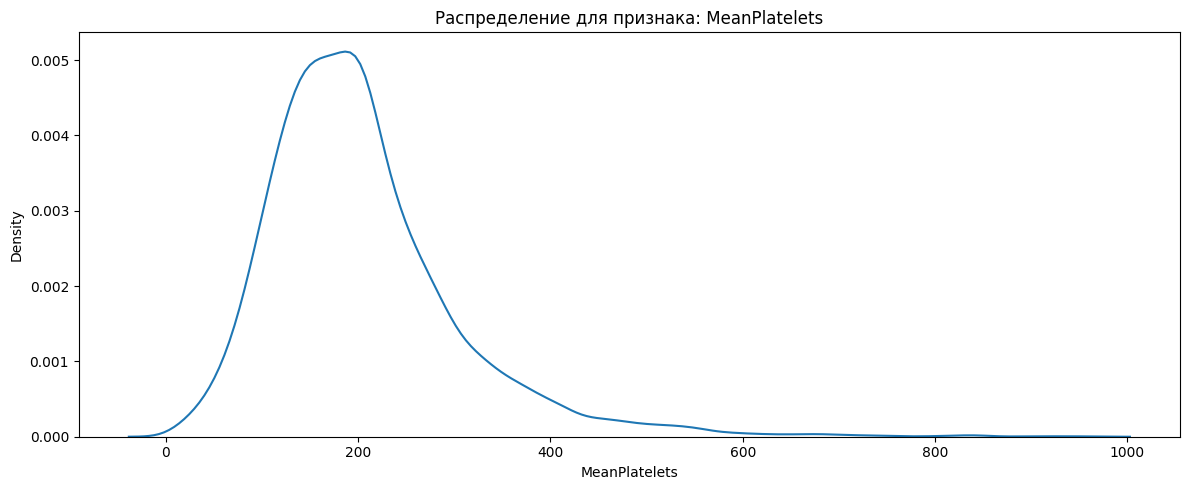

По тесту Шапиро нормальность распределения MeanPlatelets: False, p_value: 1.1125945570524759e-54
Скошенность распределения MeanPlatelets: Влево


c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6436.
  res = hypotest_fun_out(*samples, **kwds)


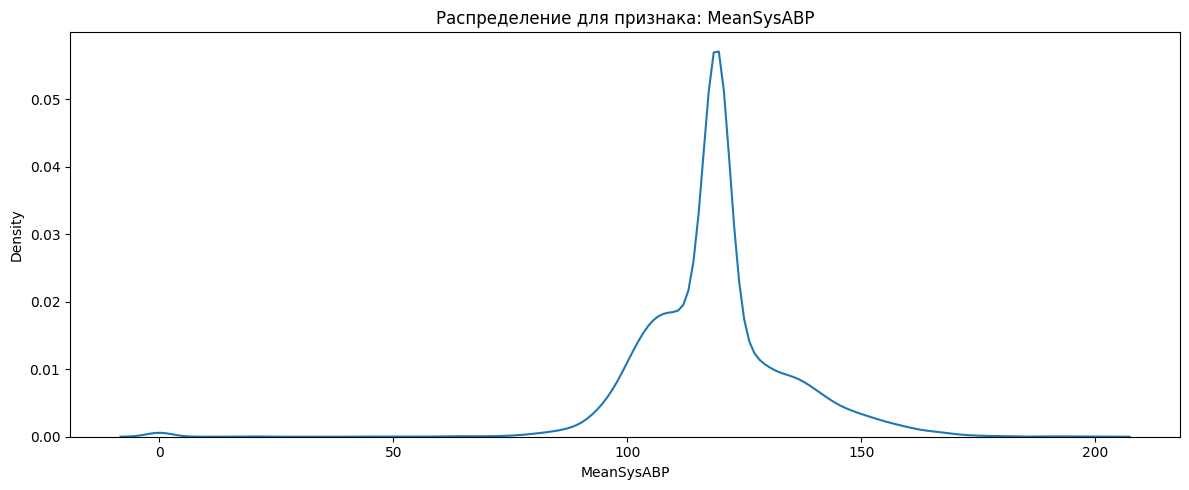

c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6436.
  res = hypotest_fun_out(*samples, **kwds)


По тесту Шапиро нормальность распределения MeanSysABP: False, p_value: 1.356359300186906e-60
Скошенность распределения MeanSysABP: Вправо


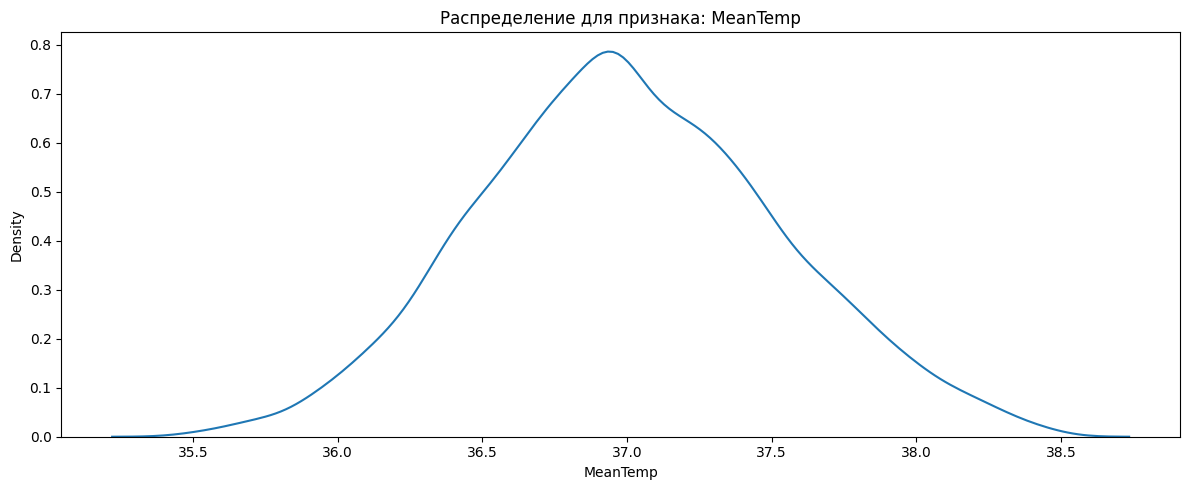

c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6436.
  res = hypotest_fun_out(*samples, **kwds)


По тесту Шапиро нормальность распределения MeanTemp: False, p_value: 2.1592714828712543e-08
Скошенность распределения MeanTemp: Влево


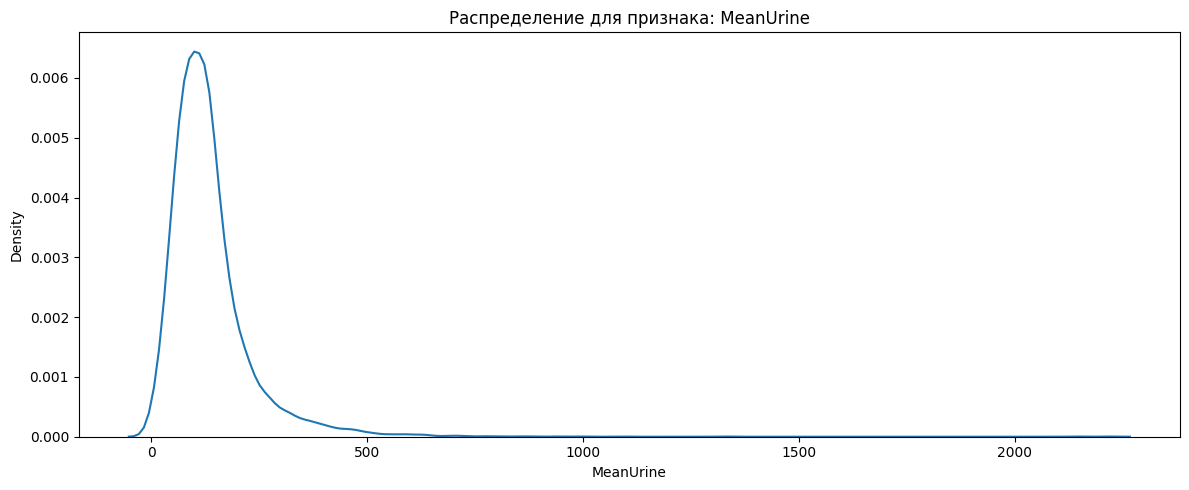

c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6436.
  res = hypotest_fun_out(*samples, **kwds)


По тесту Шапиро нормальность распределения MeanUrine: False, p_value: 2.5945662079560035e-73
Скошенность распределения MeanUrine: Влево


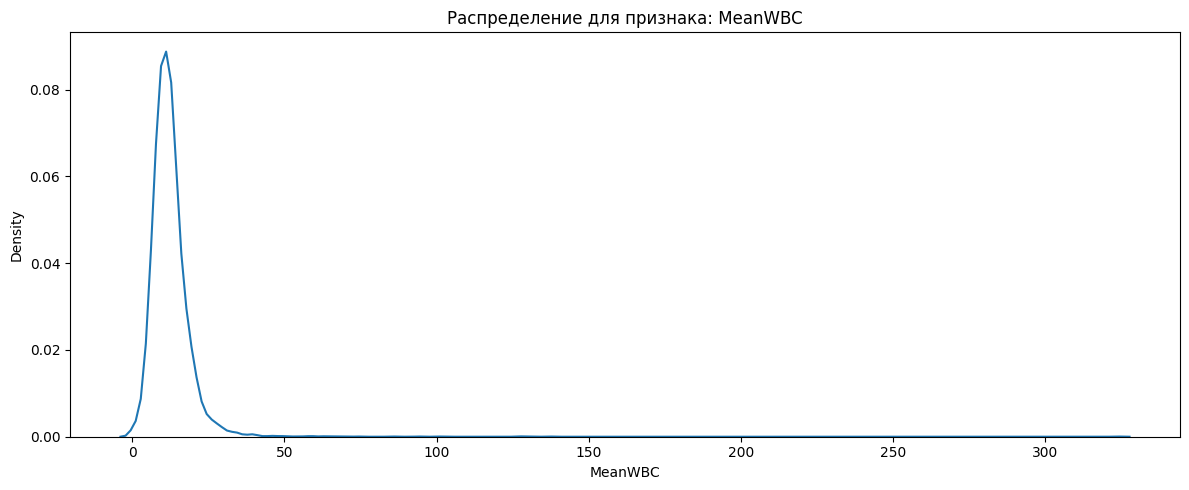

c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6436.
  res = hypotest_fun_out(*samples, **kwds)


По тесту Шапиро нормальность распределения MeanWBC: False, p_value: 1.50421078743375e-82
Скошенность распределения MeanWBC: Влево


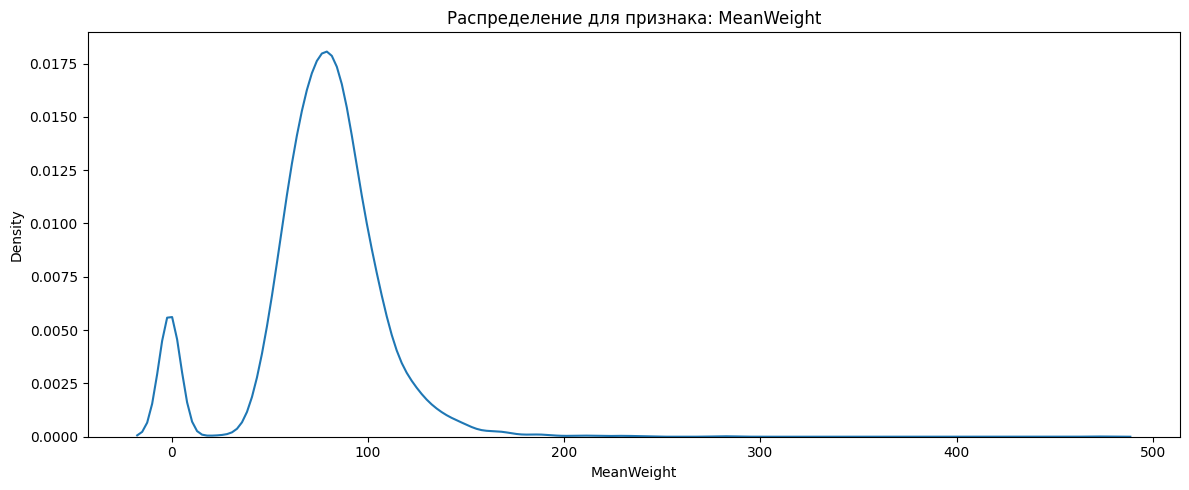

c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6436.
  res = hypotest_fun_out(*samples, **kwds)


По тесту Шапиро нормальность распределения MeanWeight: False, p_value: 5.174465619916735e-53
Скошенность распределения MeanWeight: Не выявлено


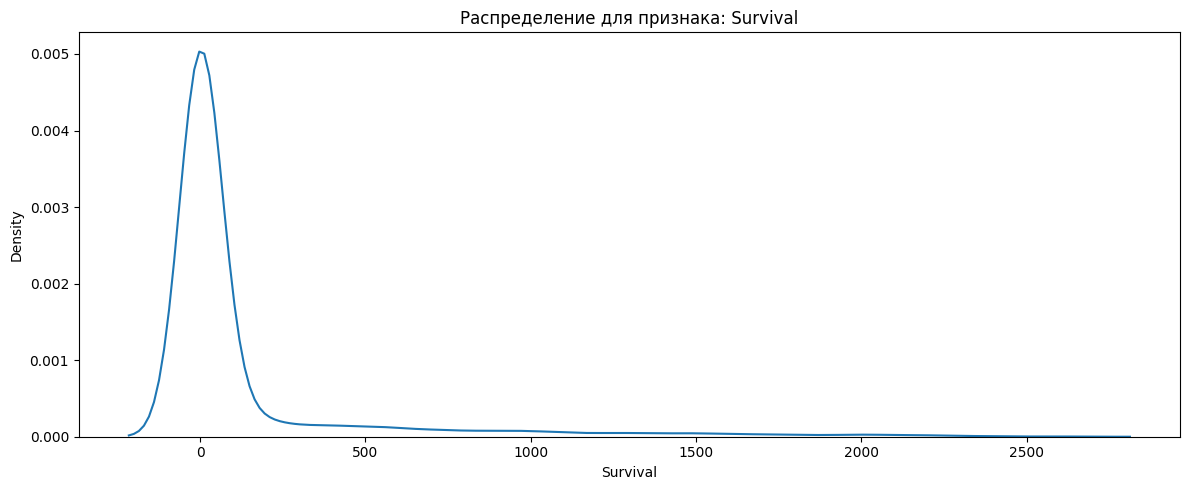

c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6436.
  res = hypotest_fun_out(*samples, **kwds)


По тесту Шапиро нормальность распределения Survival: False, p_value: 8.907385987256172e-90
Скошенность распределения Survival: Влево


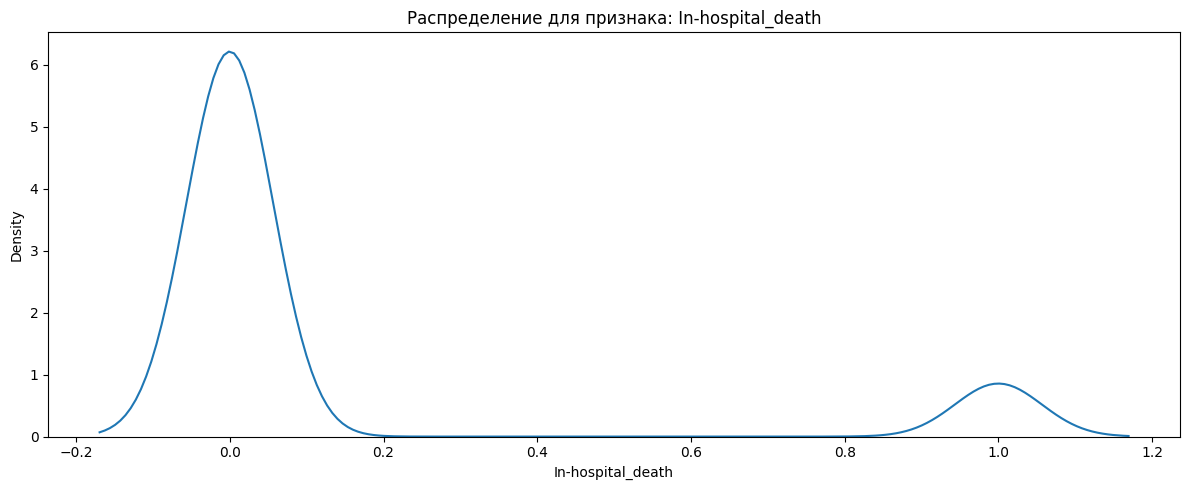

По тесту Шапиро нормальность распределения In-hospital_death: False, p_value: 2.984550992047915e-91
Скошенность распределения In-hospital_death: Влево


c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6436.
  res = hypotest_fun_out(*samples, **kwds)


In [23]:
def execute_shapiro_test(data):
    result = shapiro(data)
    p_value = result[1]
    
    return p_value

def get_assymetry(data):
    result = skew(data)

    if result > 0.1:
        return "Влево"
    elif result < -0.1:
        return "Вправо"
    return "Не выявлено"

def visual_distribution(data, column):

    fig, ax = plt.subplots(figsize=(12, 5))
    sns.kdeplot(data=data, x=column, ax=ax)
    ax.set_title(f"Распределение для признака: {column}")

    fig.tight_layout()
    plt.show()

    shapiro_p_value = execute_shapiro_test(data[column])
    print(f"По тесту Шапиро нормальность распределения {column}: {shapiro_p_value > 0.05}, p_value: {shapiro_p_value}")

    assymetry = get_assymetry(data[column])
    print(f"Скошенность распределения {column}: {assymetry}")


for col in dataset.columns:
    visual_distribution(dataset, col)

### Возможные распределения:
1. Age - распределение Вейбулла
2. Gender - распределение Бернулли
3. Height - бимодальное
4. ICUType - мультимодальное
5. MeanAlbumin - распределение Коши
6. MeanALT - мультимодальное
7. MeanBUN - экспоненциальное
8. MeanCreatinine - экспоненциальное
9. MeanDiasABP - распределение Вейбулла
10. MeanFiO2 - распределение Вейбулла
11. MeanGCS - гамма-распределение
12. MeanGlucose - гамма-распределение
13. MeanHCO3 - распределение Коши
14. MeanHCT - распределение Коши
15. MeanHR - распределение Коши
16. MeanK - распределение Коши
17. MeanMg - распределение Коши
18. MeanMAP - распределение Вейбулла
19. MeanMechVent - отсутствует
20. MeanNa - распределение Коши
21. MeanNIDiasABP - распределение Коши
22. MeanNIMAP - распределение Коши
23. MeanNISysABP - распределение Коши
24. MeanPaCO2 - распределение Коши
25. MeanPAO2 - распределение Коши
26. MeanPH - сложно определить
27. MeanPlatelets - гамма-распределение
28. MeanSysABP - распределение Вейбулла
29. MeanTemp - распределение Стьюдента
30. MeanUrine - экспоненциальное
31. MeanWBC - экспоненциальное
32. MeanWeight - бимодальное
33. Survival - экспоненциальное
34. In-hospital_death - распределение Бернулли

### Корреляционная зависимость

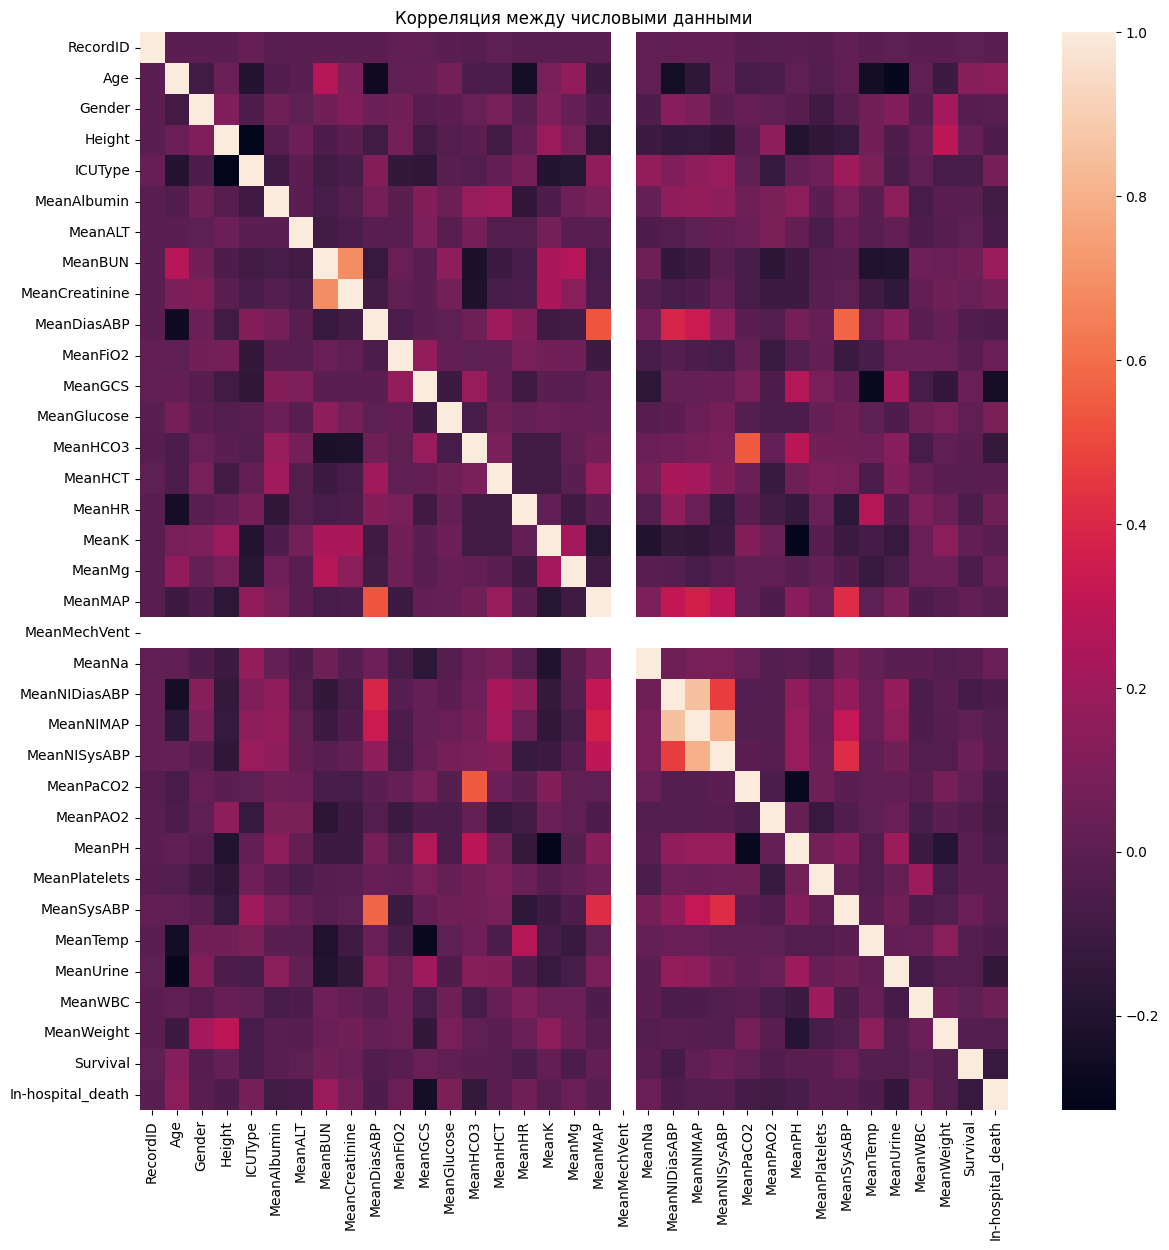

In [30]:
plt.figure(figsize=(14, 14))
sns.heatmap(dataset.corr())
plt.title("Корреляция между числовыми данными")
plt.show()

Вывод:
* Высокая положительная прямолинейная связь между (по шкале Пирсона): 
    1. MeanBUN и MeanCreatinine
    2. MeanDiasABP и MeanMAP
    3. MeanDiasABP и MeanSysABP
    4. MeanHCO3 и MeanPaCO2
    5. MeanNIDiasABP и MeanNIMAP
    6. MeanNIDiasABP и MeanNISysABP
    7. MeanNIMAP и MeanNISysABP

# Модуль В

## Отбор признаков

In [31]:
dataset

,RecordID,Age,Gender,Height,ICUType,MeanAlbumin,MeanALT,MeanBUN,MeanCreatinine,MeanDiasABP,...,MeanPAO2,MeanPH,MeanPlatelets,MeanSysABP,MeanTemp,MeanUrine,MeanWBC,MeanWeight,Survival,In-hospital_death
0,66269.5,27.0,0.0,-0.50,2.0,2.951625,161.229856,10.500000,0.750000,59.614996,...,147.385179,7.452670,203.000000,119.096129,37.357143,171.052632,10.300000,-1.000000,-1,0
1,66270.0,38.0,0.5,87.65,1.0,2.951625,161.229856,18.333333,1.100000,58.897059,...,210.142857,7.395000,178.600000,113.411765,36.939130,151.560976,11.266667,80.670588,-1,0
2,66270.5,22.0,0.0,-0.50,1.5,2.500000,83.000000,4.666667,0.333333,67.125000,...,134.500000,7.495000,89.666667,125.687500,37.800000,124.951220,4.700000,56.700000,-1,0
3,66271.5,34.0,0.5,90.15,1.5,4.400000,12.000000,17.666667,0.766667,59.614996,...,147.385179,7.452670,330.000000,119.096129,36.223077,545.833333,9.400000,84.600000,575,0
4,66272.5,44.0,0.0,-0.50,1.5,3.300000,161.229856,35.000000,1.000000,59.614996,...,147.385179,7.452670,103.000000,119.096129,36.880000,62.131579,4.300000,-1.000000,918,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7994,76424.0,32.0,0.0,-0.50,2.0,2.951625,161.229856,23.000000,1.050000,61.787234,...,121.285714,7.411429,112.500000,143.638298,37.166667,142.777778,14.250000,81.189189,2210,0
7995,76424.5,39.0,0.5,90.15,1.0,2.951625,161.229856,24.000000,1.000000,62.355932,...,159.250000,7.375625,118.250000,129.271186,36.854348,129.487805,16.766667,88.184444,752,0
7996,76425.5,45.0,0.5,88.90,1.5,2.951625,12.000000,54.571429,2.157143,45.375000,...,77.333333,7.276667,278.428571,117.416667,37.092857,20.333333,28.071429,87.096000,39,0
7997,76429.0,35.0,0.0,76.20,1.0,2.800000,11.000000,29.666667,1.600000,60.863636,...,117.500000,7.350000,189.333333,120.272727,36.600000,135.926829,14.333333,78.090566,334,0


In [24]:
Y_survival = dataset["Survival"]
Y_in_hospital_death = dataset["In-hospital_death"]
X = dataset.drop(columns=["Survival", "In-hospital_death", "RecordID"])

In [25]:
cl_model = RandomForestClassifier(random_state=42)
cl_model.fit(X, Y_in_hospital_death)

RandomForestClassifier(random_state=42)

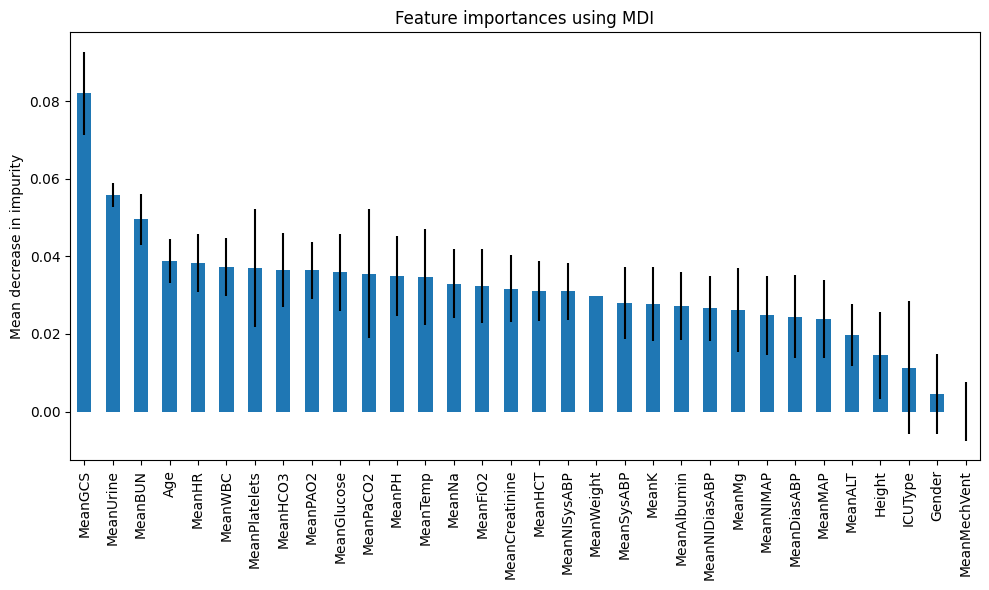

In [26]:
importances = cl_model.feature_importances_

std = np.std([tree.feature_importances_ for tree in cl_model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)


fig, ax = plt.subplots(figsize=(10, 6))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Вывод: для задачи классификации (Умрёт ли пациент в больнице) отобрали следующие признаки:
1. MeanGCS
2. MeanUrine
3. MeanBUN
4. Age
5. MeanHR
6. MeanWBC
7. MeanPlatelets
8. MeanHCO3
9. MeanPAO2
10. MeanGlucose
11. MeanPaCO2
12. MeanPH
13. MeanTemp

Причина выбора: по метрике частоты использования ML-моделью определённых признаков для предсказания

In [35]:
reg_model = RandomForestRegressor(random_state=42)
reg_model.fit(X, Y_survival)

RandomForestRegressor(random_state=42)

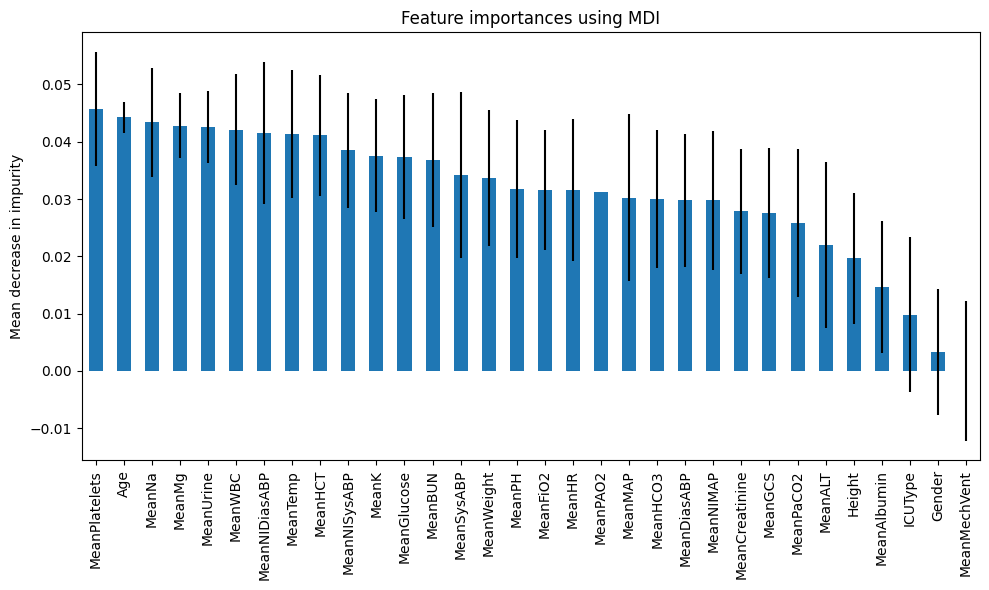

In [36]:
importances = reg_model.feature_importances_

std = np.std([tree.feature_importances_ for tree in reg_model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)


fig, ax = plt.subplots(figsize=(10, 6))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Вывод: для задачи регрессии (Кол-во дней после попадения в отделение интенсивной терапии) отобрали следующие признаки:
1. MeanPlatelets
2. Age
3. MeanMg
4. MeanUrine
5. MeanNIDiasABP
6. MeanNa
7. MeanWBC
8. MeanHCT
9. MeanTemp
10. MeanNISysABP
11. MeanK
12. MeanBUN

Причина выбора: по метрике частоты использования ML-моделью определённых признаков для предсказания

In [27]:
selected_cols = ['Age', 'MeanGCS', 'MeanUrine', 'MeanBUN', 'MeanHR', 'MeanWBC', 'MeanPlatelets',
    'MeanHCO3', 'MeanPAO2', 'MeanGlucose', 'MeanPaCO2', 'MeanPH', 'MeanTemp', 'MeanMg',
    'MeanNIDiasABP', 'MeanNa', 'MeanHCT', 'MeanNISysABP', 'MeanK']

X = dataset[selected_cols]

## Связь признаков друг с другом

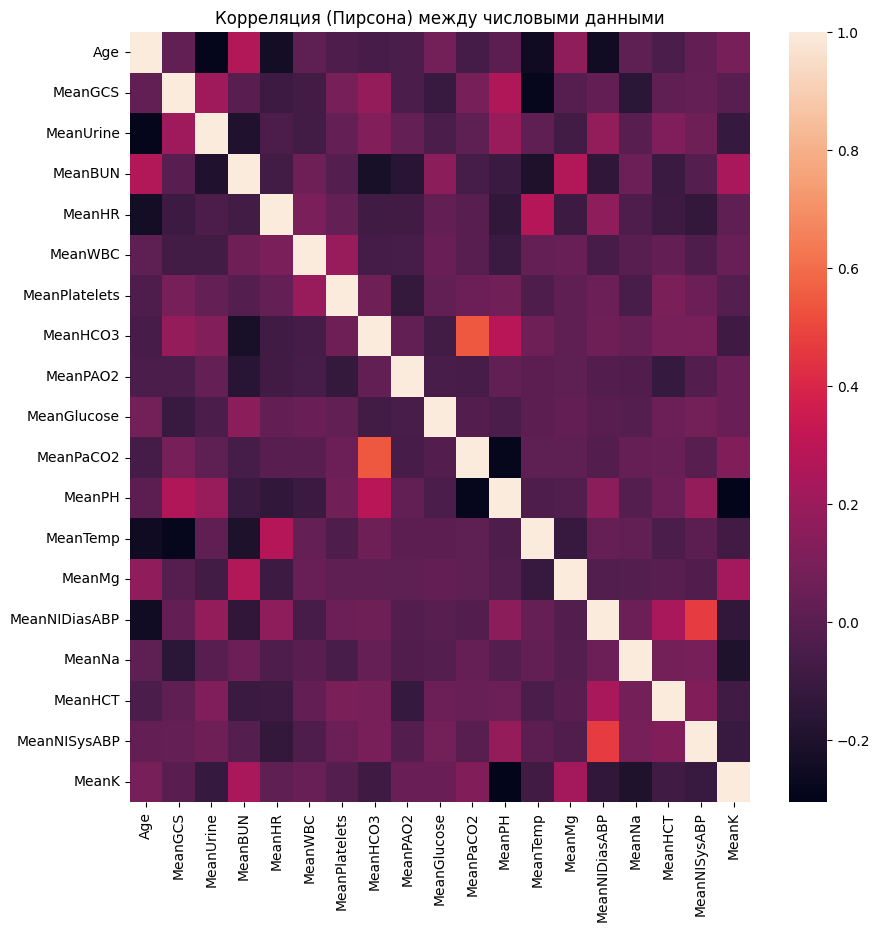

In [28]:
plt.figure(figsize=(10, 10))
sns.heatmap(X.corr(method='pearson'))
plt.title("Корреляция (Пирсона) между числовыми данными")
plt.show()

Вывод: высокая прямолинейная корреляция у следующих признаков:
1. MeanPaCO2 - MeanHCO3
2. MeanNISysABP - MeanNIDiasABP

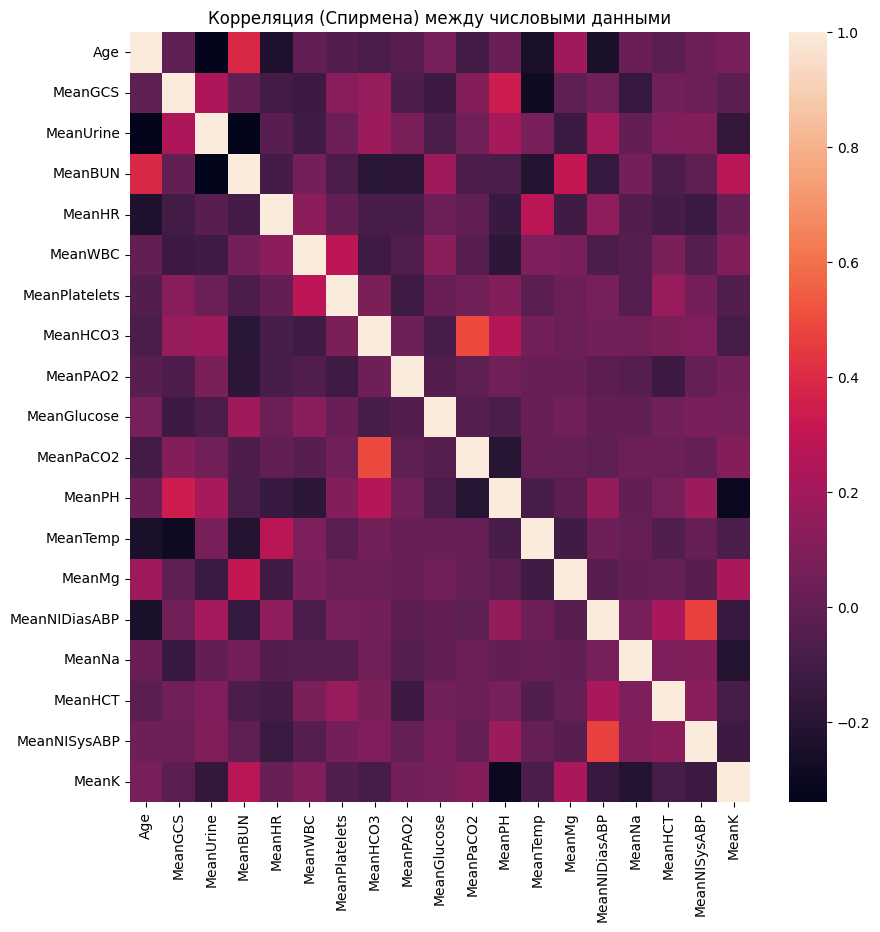

In [29]:
plt.figure(figsize=(10, 10))
sns.heatmap(X.corr(method='spearman'))
plt.title("Корреляция (Спирмена) между числовыми данными")
plt.show()

Вывод: высокая нелинейная корреляция у следующих признаков:
1. MeanPaCO2 - MeanHCO3
2. MeanNISysABP - MeanNIDiasABP
3. MeanBUN - Age

In [30]:
pairs = []
mutual_info = []

for feature1 in selected_cols:
    for feature2 in selected_cols:
        if feature1 != feature2:
            mi = mutual_info_regression(X[[feature1]], X[feature2], random_state=42)[0]
            pairs.append((feature1, feature2))
            mutual_info.append(mi)


mutual_df = pd.DataFrame({
    "Pair": pairs,
    "Score": mutual_info
})
mutual_df = mutual_df.sort_values(by="Score", ascending=False)

In [31]:
mutual_df

,Pair,Score
208,"(MeanPH, MeanPaCO2)",0.552206
190,"(MeanPaCO2, MeanPH)",0.547884
188,"(MeanPaCO2, MeanPAO2)",0.482028
154,"(MeanPAO2, MeanPH)",0.479804
206,"(MeanPH, MeanPAO2)",0.475148
...,...,...
158,"(MeanPAO2, MeanNa)",0.000000
261,"(MeanNIDiasABP, MeanGlucose)",0.000000
278,"(MeanNa, MeanPAO2)",0.000000
164,"(MeanGlucose, MeanUrine)",0.000000


Вывод: Высокая взаимная информация у следующих признаков:
1. MeanPH - MeanPaCO2
2. MeanPaCO2 - MeanPAO2
3. MeanPH - MeanPAO2

## Разделение данных на train и test

In [32]:
x_train_survival, x_test_survival, y_train_survival, y_test_survival = train_test_split(
    X, Y_survival, test_size=0.15, random_state=42
)

# x_train_survival, x_val_survival, y_train_survival, y_val_survival = train_test_split(
#     x_train_survival, y_train_survival, test_size=0.15, random_state=42
# )

In [33]:
x_train_hosp_death, x_test_hosp_death, y_train_hosp_death, y_test_hosp_death = train_test_split(
    X, Y_in_hospital_death, test_size=0.15, random_state=42
)

# x_train_hosp_death, x_val_hosp_death, y_train_hosp_death, y_val_hosp_death = train_test_split(
#     x_train_hosp_death, y_train_hosp_death, test_size=0.15, random_state=42
# )

Вывод: данные разбиты случайно, так как мы должны гарантировать непредвзятость при выборе обучающих, валидационных и тестовых данных.

## Регрессионная модель

### RandomForestRegressor

In [44]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' : ['squared_error', 'absolute_error', 'poisson', 'friedman_mse']
}

rfr = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(rfr, param_grid, cv=5, scoring = 'neg_mean_squared_error', verbose=2, n_iter=30, n_jobs=-1)
random_search.fit(x_train_survival, y_train_survival)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
95 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
52 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ba

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error',
                                                      'poisson',
                                                      'friedman_mse'],
                                        'max_depth': [4, 5, 6, 7, 8],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [200, 500]},
                   scoring='neg_mean_squared_error', verbose=2)

In [45]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(x_test_survival)

print(f"MSE: {mean_squared_error(y_test_survival, y_pred)}")
print(f"MAE: {mean_absolute_error(y_test_survival, y_pred)}")

MSE: 122373.23174025492
MAE: 200.7337243911


### GradientBoostingRegressor

In [46]:
gbr = GradientBoostingRegressor(random_state=42)
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
grid['subsample'] = [0.5, 0.7, 1.0]
grid['max_depth'] = [3, 7, 9]

random_search = RandomizedSearchCV(gbr, grid, cv=5, scoring = 'neg_mean_squared_error', verbose=2, n_iter=30, n_jobs=-1)
random_search.fit(x_train_survival, y_train_survival)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 1.0],
                                        'max_depth': [3, 7, 9],
                                        'n_estimators': [10, 50, 100, 500],
                                        'subsample': [0.5, 0.7, 1.0]},
                   scoring='neg_mean_squared_error', verbose=2)

In [47]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(x_test_survival)

print(f"MSE: {mean_squared_error(y_test_survival, y_pred)}")
print(f"MAE: {mean_absolute_error(y_test_survival, y_pred)}")

MSE: 121646.4666840741
MAE: 199.305426013123


### AdaBoostRegressor

In [48]:
ada = AdaBoostRegressor(random_state=42)
param_grid = {'n_estimators':[500,1000,2000],'learning_rate':[.001,0.01,.1],'random_state':[1]}

random_search = RandomizedSearchCV(ada, param_grid, cv=5, scoring = 'neg_mean_squared_error', verbose=2, n_iter=30, n_jobs=-1)
random_search.fit(x_train_survival, y_train_survival)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=30. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=AdaBoostRegressor(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1],
                                        'n_estimators': [500, 1000, 2000],
                                        'random_state': [1]},
                   scoring='neg_mean_squared_error', verbose=2)

In [49]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(x_test_survival)

print(f"MSE: {mean_squared_error(y_test_survival, y_pred)}")
print(f"MAE: {mean_absolute_error(y_test_survival, y_pred)}")

MSE: 122604.72657748462
MAE: 209.38833237135165


Вывод: выбираем модель GradientBoostingRegressor, так как она имеет лучшие MSE и MAE оценки.

## Классификационная модель

In [36]:
# Получение весов классов
class_weights = compute_class_weight('balanced', classes=np.unique(Y_in_hospital_death), y=Y_in_hospital_death)

### RandomForestClassifier

In [89]:
rfc = RandomForestClassifier(random_state=42, class_weight=dict(enumerate(class_weights)))

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

random_search = RandomizedSearchCV(rfc, param_grid, cv=5, scoring = 'neg_mean_squared_error', verbose=2, n_iter=50, n_jobs=-1)
random_search.fit(x_train_hosp_death, y_train_hosp_death)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight={0: 0.568852748806788,
                                                                  1: 4.130937098844672},
                                                    random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [4, 5, 6, 7, 8],
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'n_estimators': [200, 500]},
                   scoring='neg_mean_squared_error', verbose=2)

In [90]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(x_test_hosp_death)

print(classification_report(y_pred, y_test_hosp_death))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       853
           1       0.36      0.42      0.39       113

    accuracy                           0.84       966
   macro avg       0.64      0.66      0.65       966
weighted avg       0.86      0.84      0.85       966



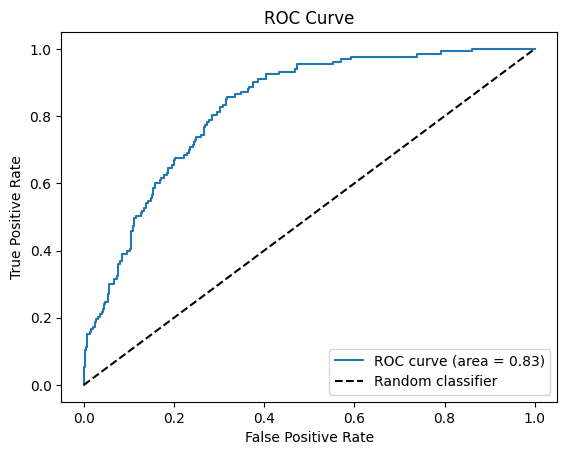

In [91]:
y_pred_prob = best_model.predict_proba(x_test_hosp_death)[:, 1]


fpr, tpr, thresholds = roc_curve(y_test_hosp_death, y_pred_prob, pos_label=1)
roc_auc = roc_auc_score(y_test_hosp_death, y_pred_prob) 
# Plot the ROC curve 
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc) 
# roc curve for tpr = fpr  
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier') 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('ROC Curve') 
plt.legend(loc="lower right") 
plt.show()

### GradientBoostingClassifier

In [92]:
gbc = GradientBoostingClassifier(random_state=42)

param_grid = {
    "loss":['exponential', 'log_loss'],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ['squared_error', 'friedman_mse'],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }

random_search = RandomizedSearchCV(gbc, param_grid, cv=5, scoring = 'neg_mean_squared_error', verbose=2, n_iter=50, n_jobs=-1)
random_search.fit(x_train_hosp_death, y_train_hosp_death)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'friedman_mse'],
                                        'learning_rate': [0.01, 0.025, 0.05,
                                                          0.075, 0.1, 0.15,
                                                          0.2],
                                        'loss': ['exponential', 'log_loss'],
                                        'max_depth': [3, 5, 8],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': array([0.1       , 0.13636364, 0.17272....20909091, 0.24545455,
       0.28181818, 0.31818182, 0.35454545, 0.39090909, 0.42727273,
       0.46363636, 0.5       ]),
                                        'min_samples_split': array([0.1       , 0.13636364, 0.17272727, 0.20909091, 0.24545455,
       0.28181818, 0.31818182, 0.35454545, 0.39090909, 0.42727273,
       0.46363636, 0.5       ]),
                                        'n_estimators': [10],
                                        'subsample': [0.5, 0.618, 0.8, 0.85,
                                                      0.9, 0.95, 1.0]},
                   scoring='neg_mean_squared_error', verbose=2)

In [93]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(x_test_hosp_death)

print(classification_report(y_pred, y_test_hosp_death))

              precision    recall  f1-score   support

           0       1.00      0.86      0.93       966
           1       0.00      0.00      0.00         0

    accuracy                           0.86       966
   macro avg       0.50      0.43      0.46       966
weighted avg       1.00      0.86      0.93       966



c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

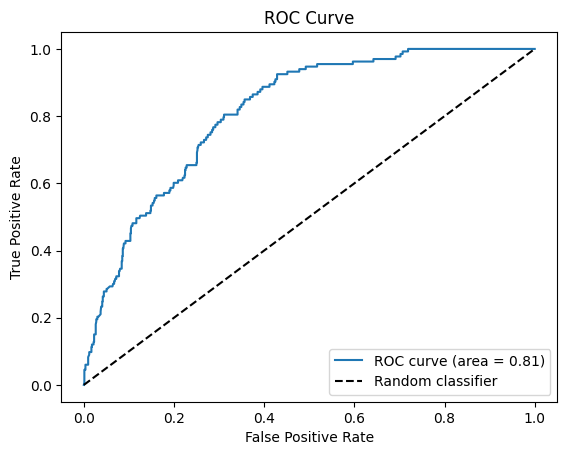

In [94]:
y_pred_prob = best_model.predict_proba(x_test_hosp_death)[:, 1]


fpr, tpr, thresholds = roc_curve(y_test_hosp_death, y_pred_prob, pos_label=1)
roc_auc = roc_auc_score(y_test_hosp_death, y_pred_prob) 
# Plot the ROC curve 
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc) 
# roc curve for tpr = fpr  
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier') 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('ROC Curve') 
plt.legend(loc="lower right") 
plt.show()

### CatBoostClassifier

In [95]:
cbc = CatBoostClassifier(random_state=42)

param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.001],
    'depth': [3, 6, 8, 10]
}

random_search = RandomizedSearchCV(cbc, param_grid, cv=5, scoring = 'neg_mean_squared_error', verbose=2, n_iter=30, n_jobs=-1)
random_search.fit(x_train_hosp_death, y_train_hosp_death)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
0:	learn: 0.6035069	total: 5.72ms	remaining: 1.71s
1:	learn: 0.5387317	total: 11.2ms	remaining: 1.66s
2:	learn: 0.4818349	total: 16.3ms	remaining: 1.61s
3:	learn: 0.4410479	total: 21.7ms	remaining: 1.6s
4:	learn: 0.4038022	total: 26.5ms	remaining: 1.56s
5:	learn: 0.3757605	total: 31.2ms	remaining: 1.53s
6:	learn: 0.3565226	total: 35.7ms	remaining: 1.49s
7:	learn: 0.3399085	total: 41.9ms	remaining: 1.53s
8:	learn: 0.3261500	total: 47.8ms	remaining: 1.55s
9:	learn: 0.3121896	total: 53.4ms	remaining: 1.55s
10:	learn: 0.3022772	total: 58.2ms	remaining: 1.53s
11:	learn: 0.2947014	total: 62.8ms	remaining: 1.51s
12:	learn: 0.2882632	total: 67.3ms	remaining: 1.49s
13:	learn: 0.2830295	total: 73ms	remaining: 1.49s
14:	learn: 0.2771486	total: 78ms	remaining: 1.48s
15:	learn: 0.2727431	total: 82.4ms	remaining: 1.46s
16:	learn: 0.2687780	total: 87.7ms	remaining: 1.46s
17:	learn: 0.2636051	total: 92.4ms	remaining: 1.45s
18:	learn: 0.2597

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x000001C7051ED3C0>,
                   n_iter=30, n_jobs=-1,
                   param_distributions={'depth': [3, 6, 8, 10],
                                        'iterations': [100, 200, 300],
                                        'learning_rate': [0.01, 0.1, 0.001]},
                   scoring='neg_mean_squared_error', verbose=2)

In [96]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(x_test_hosp_death)

print(classification_report(y_pred, y_test_hosp_death))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93       939
           1       0.11      0.56      0.19        27

    accuracy                           0.87       966
   macro avg       0.55      0.71      0.56       966
weighted avg       0.96      0.87      0.91       966



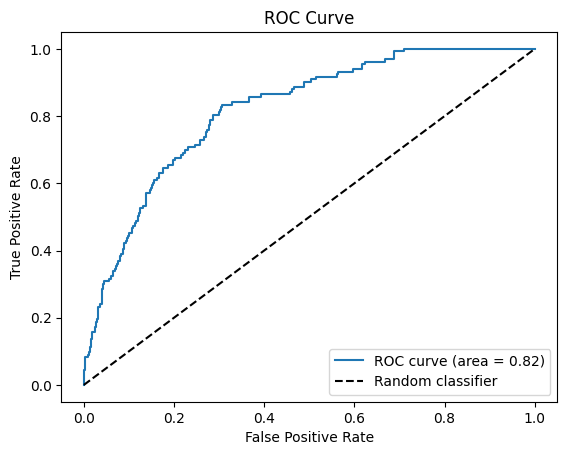

In [97]:
y_pred_prob = best_model.predict_proba(x_test_hosp_death)[:, 1]


fpr, tpr, thresholds = roc_curve(y_test_hosp_death, y_pred_prob, pos_label=1)
roc_auc = roc_auc_score(y_test_hosp_death, y_pred_prob) 
# Plot the ROC curve 
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc) 
# roc curve for tpr = fpr  
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier') 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('ROC Curve') 
plt.legend(loc="lower right") 
plt.show()

Вывод: Выбираем модель RandomForestClassifier, так как у неё лучший результат ROC-кривой, а также F1-score (особенно для реже встречающегося класса).

## Сохранение лучших моделей

In [34]:
best_reg_model = GradientBoostingRegressor(learning_rate=0.01, n_estimators=500, random_state=42,
                          subsample=0.7)

best_reg_model.fit(x_train_survival, y_train_survival)

filename = 'reg_model.sav'
pickle.dump(best_reg_model, open(filename, 'wb'))

In [37]:
best_clf_model = RandomForestClassifier(class_weight=dict(enumerate(class_weights)),
                       criterion='entropy', max_depth=8, max_features='log2',
                       n_estimators=500, random_state=42)

best_clf_model.fit(x_train_hosp_death, y_train_hosp_death)

filename = 'clf_model.sav'
pickle.dump(best_clf_model, open(filename, 'wb'))